**NLP**

*CC6205-1 - Otoño 2022*

Autor: Felipe Urrutia Vargas

In [2]:
# !pip install --upgrade pandas

import pandas as pd
import numpy as np
# pd.set_option("max_rows", None)
import pickle
from string import punctuation
import re

from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
# from astropy.visualization import hist
sns.set_theme(style="whitegrid")
plt.rc('axes', titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'lines.markeredgewidth': 1})
plt.rcParams.update({'errorbar.capsize': 2})
import random

import plotly.express as px

In [267]:
sentiments = "anger fear joy sadness".split()
intensities = "low medium high".split()

In [3]:
df_train = pickle.load(open("df_train.pickle", "rb"))

In [4]:
#import spacy library
import spacy

!python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm")

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
vocab_joy = {i: [] for i in intensities}
for i in intensities:
    _sub = df_train[(df_train["sen"] == "joy") & (df_train["int"] == i)]
    for text in _sub["text"]:
        doc = nlp(text)
        for t in doc:
            vocab_joy[i].append(t.text.lower())

In [10]:
import collections

In [14]:
frequencyDict = collections.Counter(vocab_joy["low"])
sorted(frequencyDict.items(), key=lambda x: x[1], reverse=True)

[('.', 122),
 ('the', 118),
 (',', 100),
 ('i', 99),
 ('#', 87),
 ('to', 83),
 ('a', 81),
 ('and', 65),
 ('of', 55),
 ('is', 45),
 ('it', 41),
 ("'s", 40),
 ('be', 40),
 ('that', 39),
 ('in', 38),
 ('you', 38),
 ("'", 38),
 ('...', 35),
 ("n't", 29),
 ('but', 28),
 ('with', 27),
 ('me', 27),
 ('on', 24),
 ('my', 23),
 ('for', 22),
 ('just', 20),
 ('do', 19),
 ('when', 19),
 ('so', 19),
 ('at', 19),
 ('up', 18),
 ('they', 18),
 (';', 18),
 ('-', 18),
 ('all', 18),
 ('?', 17),
 ('like', 17),
 ('was', 17),
 ('!', 17),
 ('he', 16),
 ('your', 16),
 ('or', 16),
 ('not', 16),
 ('if', 15),
 ('are', 15),
 ('out', 14),
 ('this', 14),
 ('will', 13),
 ('no', 13),
 ('&', 13),
 ('glee', 13),
 ('about', 13),
 ('who', 13),
 ('as', 12),
 ('animated', 12),
 ('would', 12),
 ('from', 12),
 ('we', 12),
 ("'re", 12),
 ('optimism', 11),
 ('some', 11),
 ('way', 11),
 (':', 11),
 ('have', 11),
 ('were', 10),
 ('she', 10),
 ('u', 10),
 ('chirp', 10),
 ('sparkling', 10),
 (':(', 9),
 ('cheer', 9),
 ('people', 9)

In [5]:
!pip install unidecode
from unidecode import unidecode

!pip install Levenshtein
import Levenshtein as lev

In [94]:
import emojilib

In [196]:
vowel = "aeiou"
digit = "0123456789"

def replace_multiple(string, list_replace, replace_ch):
    for ch in list_replace:
        if ch in string:
            string = string.replace(ch, replace_ch)
    return string

def sim_lev(a, b):
    return 1 - lev.distance(a, b) / max(len(a), len(b)) if len(a) != 0 else 0

In [218]:
tweet = df_train.iloc[123]["text"]
tweet

'@GroupAnon black armed thug with a record carrying gun illegally gets shot by black cop. #outrage   This is a joke.Let em destroy their town'

In [120]:
emo_list = emojilib.emoji_list(tweet)
emo_names = list([d['name'] for d in emo_list if 'name' in d])
emo_names

['_hugging_face_', '_OK_hand_light_skin_tone_']

In [229]:
re.findall(r"\w+", tweet)

['GroupAnon',
 'black',
 'armed',
 'thug',
 'with',
 'a',
 'record',
 'carrying',
 'gun',
 'illegally',
 'gets',
 'shot',
 'by',
 'black',
 'cop',
 'outrage',
 'This',
 'is',
 'a',
 'joke',
 'Let',
 'em',
 'destroy',
 'their',
 'town']

In [247]:
nlp_tweet = nlp(tweet)
for token in nlp_tweet:
    label = "text lemma pos tag dep shape is_alpha is_stop".split()
    vals = [token.text, token.lemma_.lower(), token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop]
    print(dict(zip(label[1:], vals[1:])))

{'lemma': '@groupanon', 'pos': 'PROPN', 'tag': 'NNP', 'dep': 'nmod', 'shape': '@XxxxxXxxx', 'is_alpha': False, 'is_stop': False}
{'lemma': 'black', 'pos': 'ADJ', 'tag': 'JJ', 'dep': 'amod', 'shape': 'xxxx', 'is_alpha': True, 'is_stop': False}
{'lemma': 'armed', 'pos': 'ADJ', 'tag': 'JJ', 'dep': 'amod', 'shape': 'xxxx', 'is_alpha': True, 'is_stop': False}
{'lemma': 'thug', 'pos': 'NOUN', 'tag': 'NN', 'dep': 'nsubjpass', 'shape': 'xxxx', 'is_alpha': True, 'is_stop': False}
{'lemma': 'with', 'pos': 'ADP', 'tag': 'IN', 'dep': 'prep', 'shape': 'xxxx', 'is_alpha': True, 'is_stop': True}
{'lemma': 'a', 'pos': 'DET', 'tag': 'DT', 'dep': 'det', 'shape': 'x', 'is_alpha': True, 'is_stop': True}
{'lemma': 'record', 'pos': 'NOUN', 'tag': 'NN', 'dep': 'compound', 'shape': 'xxxx', 'is_alpha': True, 'is_stop': False}
{'lemma': 'carry', 'pos': 'VERB', 'tag': 'VBG', 'dep': 'compound', 'shape': 'xxxx', 'is_alpha': True, 'is_stop': False}
{'lemma': 'gun', 'pos': 'NOUN', 'tag': 'NN', 'dep': 'pobj', 'shape'

In [226]:
def get_retro_attrib(tweet):
    o = {}
    o["retro<&>num_tokens"] = len(tweet.split())
    o["retro<&>lenght"] = len(" ".join(tweet.split()))
    o["retro<&>num_numbs"] = len(re.findall(r"\d+",tweet))
    o["retro<&>num_alpha"] = len(re.findall(r"\w+", tweet))
    o["retro<&>num_with_uppercase"] = len(re.findall(r"\S*[A-Z]+\S*", tweet))
    o["retro<&>num_tokens_upper"] = sum(int(t.isupper()) for t in tweet.split())
    
    def prop_vowels(w):
        N = len(w.replace(" ", ""))
        if N>0:
            return len(re.findall(r"[aeiou]", tweet)) / N
        else:
            return 0
    
    def len_max_rep_char(w):
        w=w+" "
        c0 = w[0]
        lens = [0]
        clen = 1
        for c in w[1:]:
            if c == c0:
                clen += 1
            else:
                if c0.isalpha():
                    lens.append(clen)
                c0 = c
                clen = 1
        return max(lens)  
    
    o["retro<&>prop_vowels"] = prop_vowels(tweet.lower())
    o["retro<&>len_max_rep_char"] = len_max_rep_char(tweet.lower())
    
    def max_char_fre_per_token(w, c="k"):
        tw = w.split()
        fmax = 0
        for t in tw:
            f = sum(int(ch==c) for ch in t)
            if f>fmax:
                fmax = f
        return fmax
    
    o["retro<&>max_char_fre_per_token(o)"] = max_char_fre_per_token(tweet.lower(), c="o")
    o["retro<&>max_char_fre_per_token(s)"] = max_char_fre_per_token(tweet.lower(), c="s")
    o["retro<&>max_char_fre_per_token(g)"] = max_char_fre_per_token(tweet.lower(), c="g")    
    o["retro<&>max_char_fre_per_token(l)"] = max_char_fre_per_token(tweet.lower(), c="l")    
    
    def max_type_rep_char_per_token(w, t="vowel"):
        w=unidecode(w+" ")
        c0 = w[0]
        lens = [0]
        clen = 1
        for c in w[1:]:
            if (c0.isalpha() and c.isalpha()) and ((c in "aeiou" and c0 in "aeiou") or (c not in "aeiou" and c0 not in "aeiou")):
                clen += 1
            else:
                if t=="vowel":
                    if c0 in "aeiou":
                        lens.append(clen)
                else:
                    if c0 not in "aeiou":
                        lens.append(clen) 
                c0 = c
                clen = 1
        return max(lens) 
    
    o["retro<&>max_type_rep_char_per_token(vowel)"] = max_type_rep_char_per_token(tweet.lower(), t="vowel")
    
    return o

In [122]:
def get_punct_attrib(tweet):
    o = {}
    o["punct<&>[\.]{3}"] = len(re.findall(r"[\.]{3}", tweet))
    o["punct<&>[!]"] = len(re.findall(r"[!]", tweet))
    o["punct<&>[#]"] = len(re.findall(r"[#]", tweet))
    o["punct<&>[#]{1}\S+"] = len(re.findall(r"[#]{1}\S+", tweet))
    o["punct<&>[\*]"] = len(re.findall(r"[\*]", tweet))
    o["punct<&>[@]{1}\S+"] = len(re.findall(r"[@]{1}\S+", tweet))
    o["punct<&>\S*[?]{1}\S*"] = len(re.findall(r"\S*[?]{1}\S*", tweet))
    return o

In [125]:
def get_emojilib_attrib(tweet):
    emo_list = emojilib.emoji_list(tweet)
    emo_names = list([d['name'] for d in emo_list if 'name' in d])
    o = {}
    for emo in emo_names:
        if emo not in o.keys():
            o["emoji<&>"+emo] = 0
        o["emoji<&>"+emo] += 1
    return o

In [248]:
def get_linguistics_attrib(tweet):
    o = {}
    nlp_tweet = nlp(tweet)
    for token in nlp_tweet:
        label = "text lemma pos tag dep shape is_alpha is_stop".split()
        vals = [token.text, token.lemma_.lower(), token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop]
        dict_vals = dict(zip(label[1:], vals[1:]))
        for k, v in dict_vals.items():
            l = f"linguistics<&>{k}<&>{v}"
            if l not in o.keys():
                o[l] = 0
            o[l] += 1
    return o    

In [249]:
get_retro_attrib(tweet), get_punct_attrib(tweet), get_emojilib_attrib(tweet), get_linguistics_attrib(tweet)

({'retro<&>num_tokens': 24,
  'retro<&>lenght': 138,
  'retro<&>num_numbs': 0,
  'retro<&>num_alpha': 25,
  'retro<&>num_with_uppercase': 3,
  'retro<&>num_tokens_upper': 0,
  'retro<&>prop_vowels': 0.3217391304347826,
  'retro<&>len_max_rep_char': 2,
  'retro<&>max_char_fre_per_token(o)': 2,
  'retro<&>max_char_fre_per_token(s)': 1,
  'retro<&>max_char_fre_per_token(g)': 1,
  'retro<&>max_char_fre_per_token(l)': 4,
  'retro<&>max_type_rep_char_per_token(vowel)': 2},
 {'punct<&>[\\.]{3}': 0,
  'punct<&>[!]': 0,
  'punct<&>[#]': 1,
  'punct<&>[#]{1}\\S+': 1,
  'punct<&>[\\*]': 0,
  'punct<&>[@]{1}\\S+': 1,
  'punct<&>\\S*[?]{1}\\S*': 0},
 {},
 {'linguistics<&>lemma<&>@groupanon': 1,
  'linguistics<&>pos<&>PROPN': 1,
  'linguistics<&>tag<&>NNP': 1,
  'linguistics<&>dep<&>nmod': 2,
  'linguistics<&>shape<&>@XxxxxXxxx': 1,
  'linguistics<&>is_alpha<&>False': 5,
  'linguistics<&>is_stop<&>False': 22,
  'linguistics<&>lemma<&>black': 2,
  'linguistics<&>pos<&>ADJ': 3,
  'linguistics<&>tag<&>

In [253]:
import time
import datetime

In [254]:
data_all_attributes = []
times = []
for k, ix in enumerate(df_train.index):
    start_time = time.time()
    tweet = df_train.loc[ix]["text"]
    o = {"id": ix}
    o = {**o, **get_retro_attrib(tweet)}
    o = {**o, **get_punct_attrib(tweet)}
    o = {**o, **get_emojilib_attrib(tweet)}
    o = {**o, **get_linguistics_attrib(tweet)}
    data_all_attributes.append(o)
    dt = time.time()-start_time
    times.append(dt)
    print(f"""
    row: {k+1}, total_rows: {df_train.shape[0]}
    progress: {np.round(100*(k+1)/df_train.shape[0], 3)}%
    wait time: {datetime.timedelta(seconds = np.mean(times)*(df_train.shape[0]-k-1))}s
    """)


    row: 1, total_rows: 3960
    progress: 0.025%
    wait time: 0:00:31.700853s
    

    row: 2, total_rows: 3960
    progress: 0.051%
    wait time: 0:00:27.730414s
    

    row: 3, total_rows: 3960
    progress: 0.076%
    wait time: 0:00:26.403246s
    

    row: 4, total_rows: 3960
    progress: 0.101%
    wait time: 0:00:26.727474s
    

    row: 5, total_rows: 3960
    progress: 0.126%
    wait time: 0:00:26.126756s
    

    row: 6, total_rows: 3960
    progress: 0.152%
    wait time: 0:00:24.405586s
    

    row: 7, total_rows: 3960
    progress: 0.177%
    wait time: 0:00:24.304785s
    

    row: 8, total_rows: 3960
    progress: 0.202%
    wait time: 0:00:24.228155s
    

    row: 9, total_rows: 3960
    progress: 0.227%
    wait time: 0:00:23.727308s
    

    row: 10, total_rows: 3960
    progress: 0.253%
    wait time: 0:00:23.326007s
    

    row: 11, total_rows: 3960
    progress: 0.278%
    wait time: 0:00:22.637358s
    

    row: 12, total_rows: 3960
    progre


    row: 111, total_rows: 3960
    progress: 2.803%
    wait time: 0:00:19.713710s
    

    row: 112, total_rows: 3960
    progress: 2.828%
    wait time: 0:00:19.773331s
    

    row: 113, total_rows: 3960
    progress: 2.854%
    wait time: 0:00:19.746741s
    

    row: 114, total_rows: 3960
    progress: 2.879%
    wait time: 0:00:19.754264s
    

    row: 115, total_rows: 3960
    progress: 2.904%
    wait time: 0:00:19.778182s
    

    row: 116, total_rows: 3960
    progress: 2.929%
    wait time: 0:00:19.768424s
    

    row: 117, total_rows: 3960
    progress: 2.955%
    wait time: 0:00:19.758748s
    

    row: 118, total_rows: 3960
    progress: 2.98%
    wait time: 0:00:19.651379s
    

    row: 119, total_rows: 3960
    progress: 3.005%
    wait time: 0:00:19.578102s
    

    row: 120, total_rows: 3960
    progress: 3.03%
    wait time: 0:00:19.538010s
    

    row: 121, total_rows: 3960
    progress: 3.056%
    wait time: 0:00:19.498506s
    

    row: 122, total_ro


    row: 213, total_rows: 3960
    progress: 5.379%
    wait time: 0:00:19.527780s
    

    row: 214, total_rows: 3960
    progress: 5.404%
    wait time: 0:00:19.553986s
    

    row: 215, total_rows: 3960
    progress: 5.429%
    wait time: 0:00:19.579879s
    

    row: 216, total_rows: 3960
    progress: 5.455%
    wait time: 0:00:19.589140s
    

    row: 217, total_rows: 3960
    progress: 5.48%
    wait time: 0:00:19.578964s
    

    row: 218, total_rows: 3960
    progress: 5.505%
    wait time: 0:00:19.604211s
    

    row: 219, total_rows: 3960
    progress: 5.53%
    wait time: 0:00:19.594969s
    

    row: 220, total_rows: 3960
    progress: 5.556%
    wait time: 0:00:19.585770s
    

    row: 221, total_rows: 3960
    progress: 5.581%
    wait time: 0:00:19.593535s
    

    row: 222, total_rows: 3960
    progress: 5.606%
    wait time: 0:00:19.550621s
    

    row: 223, total_rows: 3960
    progress: 5.631%
    wait time: 0:00:19.524841s
    

    row: 224, total_ro


    row: 318, total_rows: 3960
    progress: 8.03%
    wait time: 0:00:18.985871s
    

    row: 319, total_rows: 3960
    progress: 8.056%
    wait time: 0:00:18.989692s
    

    row: 320, total_rows: 3960
    progress: 8.081%
    wait time: 0:00:18.982081s
    

    row: 321, total_rows: 3960
    progress: 8.106%
    wait time: 0:00:18.974499s
    

    row: 322, total_rows: 3960
    progress: 8.131%
    wait time: 0:00:18.966901s
    

    row: 323, total_rows: 3960
    progress: 8.157%
    wait time: 0:00:18.970602s
    

    row: 324, total_rows: 3960
    progress: 8.182%
    wait time: 0:00:18.963017s
    

    row: 325, total_rows: 3960
    progress: 8.207%
    wait time: 0:00:18.977834s
    

    row: 326, total_rows: 3960
    progress: 8.232%
    wait time: 0:00:18.981357s
    

    row: 327, total_rows: 3960
    progress: 8.258%
    wait time: 0:00:18.995937s
    

    row: 328, total_rows: 3960
    progress: 8.283%
    wait time: 0:00:18.977149s
    

    row: 329, total_r


    row: 428, total_rows: 3960
    progress: 10.808%
    wait time: 0:00:18.162245s
    

    row: 429, total_rows: 3960
    progress: 10.833%
    wait time: 0:00:18.164211s
    

    row: 430, total_rows: 3960
    progress: 10.859%
    wait time: 0:00:18.157921s
    

    row: 431, total_rows: 3960
    progress: 10.884%
    wait time: 0:00:18.143440s
    

    row: 432, total_rows: 3960
    progress: 10.909%
    wait time: 0:00:18.153529s
    

    row: 433, total_rows: 3960
    progress: 10.934%
    wait time: 0:00:18.155388s
    

    row: 434, total_rows: 3960
    progress: 10.96%
    wait time: 0:00:18.149082s
    

    row: 435, total_rows: 3960
    progress: 10.985%
    wait time: 0:00:18.134666s
    

    row: 436, total_rows: 3960
    progress: 11.01%
    wait time: 0:00:18.144566s
    

    row: 437, total_rows: 3960
    progress: 11.035%
    wait time: 0:00:18.146326s
    

    row: 438, total_rows: 3960
    progress: 11.061%
    wait time: 0:00:18.139999s
    

    row: 43


    row: 530, total_rows: 3960
    progress: 13.384%
    wait time: 0:00:17.812442s
    

    row: 531, total_rows: 3960
    progress: 13.409%
    wait time: 0:00:17.812500s
    

    row: 532, total_rows: 3960
    progress: 13.434%
    wait time: 0:00:17.799633s
    

    row: 533, total_rows: 3960
    progress: 13.46%
    wait time: 0:00:17.793232s
    

    row: 534, total_rows: 3960
    progress: 13.485%
    wait time: 0:00:17.793254s
    

    row: 535, total_rows: 3960
    progress: 13.51%
    wait time: 0:00:17.786849s
    

    row: 536, total_rows: 3960
    progress: 13.535%
    wait time: 0:00:17.793238s
    

    row: 537, total_rows: 3960
    progress: 13.561%
    wait time: 0:00:17.786818s
    

    row: 538, total_rows: 3960
    progress: 13.586%
    wait time: 0:00:17.786769s
    

    row: 539, total_rows: 3960
    progress: 13.611%
    wait time: 0:00:17.780346s
    

    row: 540, total_rows: 3960
    progress: 13.636%
    wait time: 0:00:17.761248s
    

    row: 54


    row: 640, total_rows: 3960
    progress: 16.162%
    wait time: 0:00:17.112257s
    

    row: 641, total_rows: 3960
    progress: 16.187%
    wait time: 0:00:17.101140s
    

    row: 642, total_rows: 3960
    progress: 16.212%
    wait time: 0:00:17.090054s
    

    row: 643, total_rows: 3960
    progress: 16.237%
    wait time: 0:00:17.089308s
    

    row: 644, total_rows: 3960
    progress: 16.263%
    wait time: 0:00:17.088555s
    

    row: 645, total_rows: 3960
    progress: 16.288%
    wait time: 0:00:17.098066s
    

    row: 646, total_rows: 3960
    progress: 16.313%
    wait time: 0:00:17.092121s
    

    row: 647, total_rows: 3960
    progress: 16.338%
    wait time: 0:00:17.086180s
    

    row: 648, total_rows: 3960
    progress: 16.364%
    wait time: 0:00:17.080242s
    

    row: 649, total_rows: 3960
    progress: 16.389%
    wait time: 0:00:17.079414s
    

    row: 650, total_rows: 3960
    progress: 16.414%
    wait time: 0:00:17.078567s
    

    row: 


    row: 746, total_rows: 3960
    progress: 18.838%
    wait time: 0:00:16.540638s
    

    row: 747, total_rows: 3960
    progress: 18.864%
    wait time: 0:00:16.539186s
    

    row: 748, total_rows: 3960
    progress: 18.889%
    wait time: 0:00:16.537723s
    

    row: 749, total_rows: 3960
    progress: 18.914%
    wait time: 0:00:16.531955s
    

    row: 750, total_rows: 3960
    progress: 18.939%
    wait time: 0:00:16.526192s
    

    row: 751, total_rows: 3960
    progress: 18.965%
    wait time: 0:00:16.528982s
    

    row: 752, total_rows: 3960
    progress: 18.99%
    wait time: 0:00:16.514666s
    

    row: 753, total_rows: 3960
    progress: 19.015%
    wait time: 0:00:16.504645s
    

    row: 754, total_rows: 3960
    progress: 19.04%
    wait time: 0:00:16.507408s
    

    row: 755, total_rows: 3960
    progress: 19.066%
    wait time: 0:00:16.497399s
    

    row: 756, total_rows: 3960
    progress: 19.091%
    wait time: 0:00:16.491646s
    

    row: 75


    row: 863, total_rows: 3960
    progress: 21.793%
    wait time: 0:00:15.746042s
    

    row: 864, total_rows: 3960
    progress: 21.818%
    wait time: 0:00:15.744259s
    

    row: 865, total_rows: 3960
    progress: 21.843%
    wait time: 0:00:15.742466s
    

    row: 866, total_rows: 3960
    progress: 21.869%
    wait time: 0:00:15.740661s
    

    row: 867, total_rows: 3960
    progress: 21.894%
    wait time: 0:00:15.738849s
    

    row: 868, total_rows: 3960
    progress: 21.919%
    wait time: 0:00:15.733462s
    

    row: 869, total_rows: 3960
    progress: 21.944%
    wait time: 0:00:15.731638s
    

    row: 870, total_rows: 3960
    progress: 21.97%
    wait time: 0:00:15.733354s
    

    row: 871, total_rows: 3960
    progress: 21.995%
    wait time: 0:00:15.731502s
    

    row: 872, total_rows: 3960
    progress: 22.02%
    wait time: 0:00:15.726097s
    

    row: 873, total_rows: 3960
    progress: 22.045%
    wait time: 0:00:15.727772s
    

    row: 87


    row: 970, total_rows: 3960
    progress: 24.495%
    wait time: 0:00:15.197351s
    

    row: 971, total_rows: 3960
    progress: 24.52%
    wait time: 0:00:15.198192s
    

    row: 972, total_rows: 3960
    progress: 24.545%
    wait time: 0:00:15.195938s
    

    row: 973, total_rows: 3960
    progress: 24.571%
    wait time: 0:00:15.190602s
    

    row: 974, total_rows: 3960
    progress: 24.596%
    wait time: 0:00:15.185268s
    

    row: 975, total_rows: 3960
    progress: 24.621%
    wait time: 0:00:15.176869s
    

    row: 976, total_rows: 3960
    progress: 24.646%
    wait time: 0:00:15.171540s
    

    row: 977, total_rows: 3960
    progress: 24.672%
    wait time: 0:00:15.163157s
    

    row: 978, total_rows: 3960
    progress: 24.697%
    wait time: 0:00:15.163939s
    

    row: 979, total_rows: 3960
    progress: 24.722%
    wait time: 0:00:15.161654s
    

    row: 980, total_rows: 3960
    progress: 24.747%
    wait time: 0:00:15.162413s
    

    row: 9


    row: 1069, total_rows: 3960
    progress: 26.995%
    wait time: 0:00:14.824490s
    

    row: 1070, total_rows: 3960
    progress: 27.02%
    wait time: 0:00:14.819031s
    

    row: 1071, total_rows: 3960
    progress: 27.045%
    wait time: 0:00:14.818970s
    

    row: 1072, total_rows: 3960
    progress: 27.071%
    wait time: 0:00:14.812876s
    

    row: 1073, total_rows: 3960
    progress: 27.096%
    wait time: 0:00:14.810105s
    

    row: 1074, total_rows: 3960
    progress: 27.121%
    wait time: 0:00:14.810016s
    

    row: 1075, total_rows: 3960
    progress: 27.146%
    wait time: 0:00:14.807230s
    

    row: 1076, total_rows: 3960
    progress: 27.172%
    wait time: 0:00:14.801754s
    

    row: 1077, total_rows: 3960
    progress: 27.197%
    wait time: 0:00:14.796280s
    

    row: 1078, total_rows: 3960
    progress: 27.222%
    wait time: 0:00:14.793482s
    

    row: 1079, total_rows: 3960
    progress: 27.247%
    wait time: 0:00:14.790679s
    



    row: 1166, total_rows: 3960
    progress: 29.444%
    wait time: 0:00:14.427405s
    

    row: 1167, total_rows: 3960
    progress: 29.47%
    wait time: 0:00:14.424258s
    

    row: 1168, total_rows: 3960
    progress: 29.495%
    wait time: 0:00:14.423494s
    

    row: 1169, total_rows: 3960
    progress: 29.52%
    wait time: 0:00:14.420332s
    

    row: 1170, total_rows: 3960
    progress: 29.545%
    wait time: 0:00:14.419555s
    

    row: 1171, total_rows: 3960
    progress: 29.571%
    wait time: 0:00:14.411612s
    

    row: 1172, total_rows: 3960
    progress: 29.596%
    wait time: 0:00:14.403675s
    

    row: 1173, total_rows: 3960
    progress: 29.621%
    wait time: 0:00:14.400503s
    

    row: 1174, total_rows: 3960
    progress: 29.646%
    wait time: 0:00:14.399701s
    

    row: 1175, total_rows: 3960
    progress: 29.672%
    wait time: 0:00:14.398888s
    

    row: 1176, total_rows: 3960
    progress: 29.697%
    wait time: 0:00:14.398065s
    




    row: 1266, total_rows: 3960
    progress: 31.97%
    wait time: 0:00:13.979398s
    

    row: 1267, total_rows: 3960
    progress: 31.995%
    wait time: 0:00:13.975945s
    

    row: 1268, total_rows: 3960
    progress: 32.02%
    wait time: 0:00:13.968238s
    

    row: 1269, total_rows: 3960
    progress: 32.045%
    wait time: 0:00:13.960535s
    

    row: 1270, total_rows: 3960
    progress: 32.071%
    wait time: 0:00:13.954959s
    

    row: 1271, total_rows: 3960
    progress: 32.096%
    wait time: 0:00:13.953619s
    

    row: 1272, total_rows: 3960
    progress: 32.121%
    wait time: 0:00:13.950154s
    

    row: 1273, total_rows: 3960
    progress: 32.146%
    wait time: 0:00:13.948799s
    

    row: 1274, total_rows: 3960
    progress: 32.172%
    wait time: 0:00:13.945325s
    

    row: 1275, total_rows: 3960
    progress: 32.197%
    wait time: 0:00:13.941846s
    

    row: 1276, total_rows: 3960
    progress: 32.222%
    wait time: 0:00:13.934154s
    




    row: 1362, total_rows: 3960
    progress: 34.394%
    wait time: 0:00:13.556284s
    

    row: 1363, total_rows: 3960
    progress: 34.419%
    wait time: 0:00:13.548753s
    

    row: 1364, total_rows: 3960
    progress: 34.444%
    wait time: 0:00:13.543131s
    

    row: 1365, total_rows: 3960
    progress: 34.47%
    wait time: 0:00:13.537511s
    

    row: 1366, total_rows: 3960
    progress: 34.495%
    wait time: 0:00:13.533793s
    

    row: 1367, total_rows: 3960
    progress: 34.52%
    wait time: 0:00:13.528170s
    

    row: 1368, total_rows: 3960
    progress: 34.545%
    wait time: 0:00:13.524447s
    

    row: 1369, total_rows: 3960
    progress: 34.571%
    wait time: 0:00:13.518826s
    

    row: 1370, total_rows: 3960
    progress: 34.596%
    wait time: 0:00:13.515100s
    

    row: 1371, total_rows: 3960
    progress: 34.621%
    wait time: 0:00:13.509475s
    

    row: 1372, total_rows: 3960
    progress: 34.646%
    wait time: 0:00:13.501967s
    




    row: 1459, total_rows: 3960
    progress: 36.843%
    wait time: 0:00:13.121031s
    

    row: 1460, total_rows: 3960
    progress: 36.869%
    wait time: 0:00:13.117086s
    

    row: 1461, total_rows: 3960
    progress: 36.894%
    wait time: 0:00:13.111423s
    

    row: 1462, total_rows: 3960
    progress: 36.919%
    wait time: 0:00:13.107473s
    

    row: 1463, total_rows: 3960
    progress: 36.944%
    wait time: 0:00:13.101812s
    

    row: 1464, total_rows: 3960
    progress: 36.97%
    wait time: 0:00:13.096153s
    

    row: 1465, total_rows: 3960
    progress: 36.995%
    wait time: 0:00:13.092197s
    

    row: 1466, total_rows: 3960
    progress: 37.02%
    wait time: 0:00:13.088238s
    

    row: 1467, total_rows: 3960
    progress: 37.045%
    wait time: 0:00:13.080877s
    

    row: 1468, total_rows: 3960
    progress: 37.071%
    wait time: 0:00:13.076916s
    

    row: 1469, total_rows: 3960
    progress: 37.096%
    wait time: 0:00:13.072954s
    




    row: 1579, total_rows: 3960
    progress: 39.874%
    wait time: 0:00:12.766178s
    

    row: 1580, total_rows: 3960
    progress: 39.899%
    wait time: 0:00:12.761787s
    

    row: 1581, total_rows: 3960
    progress: 39.924%
    wait time: 0:00:12.755886s
    

    row: 1582, total_rows: 3960
    progress: 39.949%
    wait time: 0:00:12.754501s
    

    row: 1583, total_rows: 3960
    progress: 39.975%
    wait time: 0:00:12.747096s
    

    row: 1584, total_rows: 3960
    progress: 40.0%
    wait time: 0:00:12.739695s
    

    row: 1585, total_rows: 3960
    progress: 40.025%
    wait time: 0:00:12.733799s
    

    row: 1586, total_rows: 3960
    progress: 40.051%
    wait time: 0:00:12.729400s
    

    row: 1587, total_rows: 3960
    progress: 40.076%
    wait time: 0:00:12.723504s
    

    row: 1588, total_rows: 3960
    progress: 40.101%
    wait time: 0:00:12.719104s
    

    row: 1589, total_rows: 3960
    progress: 40.126%
    wait time: 0:00:12.713208s
    




    row: 1676, total_rows: 3960
    progress: 42.323%
    wait time: 0:00:12.277161s
    

    row: 1677, total_rows: 3960
    progress: 42.348%
    wait time: 0:00:12.274006s
    

    row: 1678, total_rows: 3960
    progress: 42.374%
    wait time: 0:00:12.269486s
    

    row: 1679, total_rows: 3960
    progress: 42.399%
    wait time: 0:00:12.266323s
    

    row: 1680, total_rows: 3960
    progress: 42.424%
    wait time: 0:00:12.263155s
    

    row: 1681, total_rows: 3960
    progress: 42.449%
    wait time: 0:00:12.259984s
    

    row: 1682, total_rows: 3960
    progress: 42.475%
    wait time: 0:00:12.254097s
    

    row: 1683, total_rows: 3960
    progress: 42.5%
    wait time: 0:00:12.250918s
    

    row: 1684, total_rows: 3960
    progress: 42.525%
    wait time: 0:00:12.247736s
    

    row: 1685, total_rows: 3960
    progress: 42.551%
    wait time: 0:00:12.243196s
    

    row: 1686, total_rows: 3960
    progress: 42.576%
    wait time: 0:00:12.238658s
    




    row: 1771, total_rows: 3960
    progress: 44.722%
    wait time: 0:00:11.805249s
    

    row: 1772, total_rows: 3960
    progress: 44.747%
    wait time: 0:00:11.801847s
    

    row: 1773, total_rows: 3960
    progress: 44.773%
    wait time: 0:00:11.797208s
    

    row: 1774, total_rows: 3960
    progress: 44.798%
    wait time: 0:00:11.795031s
    

    row: 1775, total_rows: 3960
    progress: 44.823%
    wait time: 0:00:11.791618s
    

    row: 1776, total_rows: 3960
    progress: 44.848%
    wait time: 0:00:11.788202s
    

    row: 1777, total_rows: 3960
    progress: 44.874%
    wait time: 0:00:11.781092s
    

    row: 1778, total_rows: 3960
    progress: 44.899%
    wait time: 0:00:11.773985s
    

    row: 1779, total_rows: 3960
    progress: 44.924%
    wait time: 0:00:11.768109s
    

    row: 1780, total_rows: 3960
    progress: 44.949%
    wait time: 0:00:11.762235s
    

    row: 1781, total_rows: 3960
    progress: 44.975%
    wait time: 0:00:11.755135s
    


    row: 1872, total_rows: 3960
    progress: 47.273%
    wait time: 0:00:11.240240s
    

    row: 1873, total_rows: 3960
    progress: 47.298%
    wait time: 0:00:11.234435s
    

    row: 1874, total_rows: 3960
    progress: 47.323%
    wait time: 0:00:11.231974s
    

    row: 1875, total_rows: 3960
    progress: 47.348%
    wait time: 0:00:11.226167s
    

    row: 1876, total_rows: 3960
    progress: 47.374%
    wait time: 0:00:11.220361s
    

    row: 1877, total_rows: 3960
    progress: 47.399%
    wait time: 0:00:11.213444s
    

    row: 1878, total_rows: 3960
    progress: 47.424%
    wait time: 0:00:11.209861s
    

    row: 1879, total_rows: 3960
    progress: 47.449%
    wait time: 0:00:11.204055s
    

    row: 1880, total_rows: 3960
    progress: 47.475%
    wait time: 0:00:11.199359s
    

    row: 1881, total_rows: 3960
    progress: 47.5%
    wait time: 0:00:11.193555s
    

    row: 1882, total_rows: 3960
    progress: 47.525%
    wait time: 0:00:11.189962s
    




    row: 1974, total_rows: 3960
    progress: 49.848%
    wait time: 0:00:10.675448s
    

    row: 1975, total_rows: 3960
    progress: 49.874%
    wait time: 0:00:10.669700s
    

    row: 1976, total_rows: 3960
    progress: 49.899%
    wait time: 0:00:10.663953s
    

    row: 1977, total_rows: 3960
    progress: 49.924%
    wait time: 0:00:10.659210s
    

    row: 1978, total_rows: 3960
    progress: 49.949%
    wait time: 0:00:10.654467s
    

    row: 1979, total_rows: 3960
    progress: 49.975%
    wait time: 0:00:10.649722s
    

    row: 1980, total_rows: 3960
    progress: 50.0%
    wait time: 0:00:10.645976s
    

    row: 1981, total_rows: 3960
    progress: 50.025%
    wait time: 0:00:10.641227s
    

    row: 1982, total_rows: 3960
    progress: 50.051%
    wait time: 0:00:10.635479s
    

    row: 1983, total_rows: 3960
    progress: 50.076%
    wait time: 0:00:10.630728s
    

    row: 1984, total_rows: 3960
    progress: 50.101%
    wait time: 0:00:10.625976s
    




    row: 2075, total_rows: 3960
    progress: 52.399%
    wait time: 0:00:10.125795s
    

    row: 2076, total_rows: 3960
    progress: 52.424%
    wait time: 0:00:10.120089s
    

    row: 2077, total_rows: 3960
    progress: 52.449%
    wait time: 0:00:10.113478s
    

    row: 2078, total_rows: 3960
    progress: 52.475%
    wait time: 0:00:10.107775s
    

    row: 2079, total_rows: 3960
    progress: 52.5%
    wait time: 0:00:10.102979s
    

    row: 2080, total_rows: 3960
    progress: 52.525%
    wait time: 0:00:10.096371s
    

    row: 2081, total_rows: 3960
    progress: 52.551%
    wait time: 0:00:10.090670s
    

    row: 2082, total_rows: 3960
    progress: 52.576%
    wait time: 0:00:10.085873s
    

    row: 2083, total_rows: 3960
    progress: 52.601%
    wait time: 0:00:10.078369s
    

    row: 2084, total_rows: 3960
    progress: 52.626%
    wait time: 0:00:10.072671s
    

    row: 2085, total_rows: 3960
    progress: 52.652%
    wait time: 0:00:10.067874s
    




    row: 2175, total_rows: 3960
    progress: 54.924%
    wait time: 0:00:09.588050s
    

    row: 2176, total_rows: 3960
    progress: 54.949%
    wait time: 0:00:09.583199s
    

    row: 2177, total_rows: 3960
    progress: 54.975%
    wait time: 0:00:09.577526s
    

    row: 2178, total_rows: 3960
    progress: 55.0%
    wait time: 0:00:09.571854s
    

    row: 2179, total_rows: 3960
    progress: 55.025%
    wait time: 0:00:09.566183s
    

    row: 2180, total_rows: 3960
    progress: 55.051%
    wait time: 0:00:09.562146s
    

    row: 2181, total_rows: 3960
    progress: 55.076%
    wait time: 0:00:09.556070s
    

    row: 2182, total_rows: 3960
    progress: 55.101%
    wait time: 0:00:09.549583s
    

    row: 2183, total_rows: 3960
    progress: 55.126%
    wait time: 0:00:09.542285s
    

    row: 2184, total_rows: 3960
    progress: 55.152%
    wait time: 0:00:09.534989s
    

    row: 2185, total_rows: 3960
    progress: 55.177%
    wait time: 0:00:09.529325s
    




    row: 2274, total_rows: 3960
    progress: 57.424%
    wait time: 0:00:09.057075s
    

    row: 2275, total_rows: 3960
    progress: 57.449%
    wait time: 0:00:09.052913s
    

    row: 2276, total_rows: 3960
    progress: 57.475%
    wait time: 0:00:09.048009s
    

    row: 2277, total_rows: 3960
    progress: 57.5%
    wait time: 0:00:09.043103s
    

    row: 2278, total_rows: 3960
    progress: 57.525%
    wait time: 0:00:09.038197s
    

    row: 2279, total_rows: 3960
    progress: 57.551%
    wait time: 0:00:09.032551s
    

    row: 2280, total_rows: 3960
    progress: 57.576%
    wait time: 0:00:09.026906s
    

    row: 2281, total_rows: 3960
    progress: 57.601%
    wait time: 0:00:09.024209s
    

    row: 2282, total_rows: 3960
    progress: 57.626%
    wait time: 0:00:09.017826s
    

    row: 2283, total_rows: 3960
    progress: 57.652%
    wait time: 0:00:09.011445s
    

    row: 2284, total_rows: 3960
    progress: 57.677%
    wait time: 0:00:09.006536s
    




    row: 2375, total_rows: 3960
    progress: 59.975%
    wait time: 0:00:08.515887s
    

    row: 2376, total_rows: 3960
    progress: 60.0%
    wait time: 0:00:08.511604s
    

    row: 2377, total_rows: 3960
    progress: 60.025%
    wait time: 0:00:08.506652s
    

    row: 2378, total_rows: 3960
    progress: 60.051%
    wait time: 0:00:08.501032s
    

    row: 2379, total_rows: 3960
    progress: 60.076%
    wait time: 0:00:08.494083s
    

    row: 2380, total_rows: 3960
    progress: 60.101%
    wait time: 0:00:08.488465s
    

    row: 2381, total_rows: 3960
    progress: 60.126%
    wait time: 0:00:08.484176s
    

    row: 2382, total_rows: 3960
    progress: 60.152%
    wait time: 0:00:08.479886s
    

    row: 2383, total_rows: 3960
    progress: 60.177%
    wait time: 0:00:08.474929s
    

    row: 2384, total_rows: 3960
    progress: 60.202%
    wait time: 0:00:08.468649s
    

    row: 2385, total_rows: 3960
    progress: 60.227%
    wait time: 0:00:08.462371s
    




    row: 2475, total_rows: 3960
    progress: 62.5%
    wait time: 0:00:07.969750s
    

    row: 2476, total_rows: 3960
    progress: 62.525%
    wait time: 0:00:07.964166s
    

    row: 2477, total_rows: 3960
    progress: 62.551%
    wait time: 0:00:07.957984s
    

    row: 2478, total_rows: 3960
    progress: 62.576%
    wait time: 0:00:07.951803s
    

    row: 2479, total_rows: 3960
    progress: 62.601%
    wait time: 0:00:07.947417s
    

    row: 2480, total_rows: 3960
    progress: 62.626%
    wait time: 0:00:07.942432s
    

    row: 2481, total_rows: 3960
    progress: 62.652%
    wait time: 0:00:07.937447s
    

    row: 2482, total_rows: 3960
    progress: 62.677%
    wait time: 0:00:07.932460s
    

    row: 2483, total_rows: 3960
    progress: 62.702%
    wait time: 0:00:07.926282s
    

    row: 2484, total_rows: 3960
    progress: 62.727%
    wait time: 0:00:07.921297s
    

    row: 2485, total_rows: 3960
    progress: 62.753%
    wait time: 0:00:07.915121s
    




    row: 2577, total_rows: 3960
    progress: 65.076%
    wait time: 0:00:07.416468s
    

    row: 2578, total_rows: 3960
    progress: 65.101%
    wait time: 0:00:07.410377s
    

    row: 2579, total_rows: 3960
    progress: 65.126%
    wait time: 0:00:07.405359s
    

    row: 2580, total_rows: 3960
    progress: 65.152%
    wait time: 0:00:07.400341s
    

    row: 2581, total_rows: 3960
    progress: 65.177%
    wait time: 0:00:07.395322s
    

    row: 2582, total_rows: 3960
    progress: 65.202%
    wait time: 0:00:07.389768s
    

    row: 2583, total_rows: 3960
    progress: 65.227%
    wait time: 0:00:07.384748s
    

    row: 2584, total_rows: 3960
    progress: 65.253%
    wait time: 0:00:07.380793s
    

    row: 2585, total_rows: 3960
    progress: 65.278%
    wait time: 0:00:07.375770s
    

    row: 2586, total_rows: 3960
    progress: 65.303%
    wait time: 0:00:07.370747s
    

    row: 2587, total_rows: 3960
    progress: 65.328%
    wait time: 0:00:07.366254s
    


    row: 2676, total_rows: 3960
    progress: 67.576%
    wait time: 0:00:06.877687s
    

    row: 2677, total_rows: 3960
    progress: 67.601%
    wait time: 0:00:06.872161s
    

    row: 2678, total_rows: 3960
    progress: 67.626%
    wait time: 0:00:06.866637s
    

    row: 2679, total_rows: 3960
    progress: 67.652%
    wait time: 0:00:06.861591s
    

    row: 2680, total_rows: 3960
    progress: 67.677%
    wait time: 0:00:06.857023s
    

    row: 2681, total_rows: 3960
    progress: 67.702%
    wait time: 0:00:06.852453s
    

    row: 2682, total_rows: 3960
    progress: 67.727%
    wait time: 0:00:06.845973s
    

    row: 2683, total_rows: 3960
    progress: 67.753%
    wait time: 0:00:06.840925s
    

    row: 2684, total_rows: 3960
    progress: 67.778%
    wait time: 0:00:06.835876s
    

    row: 2685, total_rows: 3960
    progress: 67.803%
    wait time: 0:00:06.830827s
    

    row: 2686, total_rows: 3960
    progress: 67.828%
    wait time: 0:00:06.824827s
    


    row: 2770, total_rows: 3960
    progress: 69.949%
    wait time: 0:00:06.384696s
    

    row: 2771, total_rows: 3960
    progress: 69.975%
    wait time: 0:00:06.379176s
    

    row: 2772, total_rows: 3960
    progress: 70.0%
    wait time: 0:00:06.374085s
    

    row: 2773, total_rows: 3960
    progress: 70.025%
    wait time: 0:00:06.368138s
    

    row: 2774, total_rows: 3960
    progress: 70.051%
    wait time: 0:00:06.363475s
    

    row: 2775, total_rows: 3960
    progress: 70.076%
    wait time: 0:00:06.357955s
    

    row: 2776, total_rows: 3960
    progress: 70.101%
    wait time: 0:00:06.352863s
    

    row: 2777, total_rows: 3960
    progress: 70.126%
    wait time: 0:00:06.347770s
    

    row: 2778, total_rows: 3960
    progress: 70.152%
    wait time: 0:00:06.342250s
    

    row: 2779, total_rows: 3960
    progress: 70.177%
    wait time: 0:00:06.336731s
    

    row: 2780, total_rows: 3960
    progress: 70.202%
    wait time: 0:00:06.331212s
    




    row: 2867, total_rows: 3960
    progress: 72.399%
    wait time: 0:00:05.866567s
    

    row: 2868, total_rows: 3960
    progress: 72.424%
    wait time: 0:00:05.861826s
    

    row: 2869, total_rows: 3960
    progress: 72.449%
    wait time: 0:00:05.855939s
    

    row: 2870, total_rows: 3960
    progress: 72.475%
    wait time: 0:00:05.850434s
    

    row: 2871, total_rows: 3960
    progress: 72.5%
    wait time: 0:00:05.844929s
    

    row: 2872, total_rows: 3960
    progress: 72.525%
    wait time: 0:00:05.840182s
    

    row: 2873, total_rows: 3960
    progress: 72.551%
    wait time: 0:00:05.835056s
    

    row: 2874, total_rows: 3960
    progress: 72.576%
    wait time: 0:00:05.829551s
    

    row: 2875, total_rows: 3960
    progress: 72.601%
    wait time: 0:00:05.824046s
    

    row: 2876, total_rows: 3960
    progress: 72.626%
    wait time: 0:00:05.819296s
    

    row: 2877, total_rows: 3960
    progress: 72.652%
    wait time: 0:00:05.813037s
    




    row: 2966, total_rows: 3960
    progress: 74.899%
    wait time: 0:00:05.333555s
    

    row: 2967, total_rows: 3960
    progress: 74.924%
    wait time: 0:00:05.328068s
    

    row: 2968, total_rows: 3960
    progress: 74.949%
    wait time: 0:00:05.322916s
    

    row: 2969, total_rows: 3960
    progress: 74.975%
    wait time: 0:00:05.317096s
    

    row: 2970, total_rows: 3960
    progress: 75.0%
    wait time: 0:00:05.312277s
    

    row: 2971, total_rows: 3960
    progress: 75.025%
    wait time: 0:00:05.307458s
    

    row: 2972, total_rows: 3960
    progress: 75.051%
    wait time: 0:00:05.302304s
    

    row: 2973, total_rows: 3960
    progress: 75.076%
    wait time: 0:00:05.297149s
    

    row: 2974, total_rows: 3960
    progress: 75.101%
    wait time: 0:00:05.291662s
    

    row: 2975, total_rows: 3960
    progress: 75.126%
    wait time: 0:00:05.286507s
    

    row: 2976, total_rows: 3960
    progress: 75.152%
    wait time: 0:00:05.281020s
    




    row: 3058, total_rows: 3960
    progress: 77.222%
    wait time: 0:00:04.849863s
    

    row: 3059, total_rows: 3960
    progress: 77.247%
    wait time: 0:00:04.844671s
    

    row: 3060, total_rows: 3960
    progress: 77.273%
    wait time: 0:00:04.839185s
    

    row: 3061, total_rows: 3960
    progress: 77.298%
    wait time: 0:00:04.833993s
    

    row: 3062, total_rows: 3960
    progress: 77.323%
    wait time: 0:00:04.828800s
    

    row: 3063, total_rows: 3960
    progress: 77.348%
    wait time: 0:00:04.823607s
    

    row: 3064, total_rows: 3960
    progress: 77.374%
    wait time: 0:00:04.818120s
    

    row: 3065, total_rows: 3960
    progress: 77.399%
    wait time: 0:00:04.812926s
    

    row: 3066, total_rows: 3960
    progress: 77.424%
    wait time: 0:00:04.807732s
    

    row: 3067, total_rows: 3960
    progress: 77.449%
    wait time: 0:00:04.802828s
    

    row: 3068, total_rows: 3960
    progress: 77.475%
    wait time: 0:00:04.797341s
    


    row: 3160, total_rows: 3960
    progress: 79.798%
    wait time: 0:00:04.295365s
    

    row: 3161, total_rows: 3960
    progress: 79.823%
    wait time: 0:00:04.289904s
    

    row: 3162, total_rows: 3960
    progress: 79.848%
    wait time: 0:00:04.284696s
    

    row: 3163, total_rows: 3960
    progress: 79.874%
    wait time: 0:00:04.279487s
    

    row: 3164, total_rows: 3960
    progress: 79.899%
    wait time: 0:00:04.274277s
    

    row: 3165, total_rows: 3960
    progress: 79.924%
    wait time: 0:00:04.268564s
    

    row: 3166, total_rows: 3960
    progress: 79.949%
    wait time: 0:00:04.263103s
    

    row: 3167, total_rows: 3960
    progress: 79.975%
    wait time: 0:00:04.257893s
    

    row: 3168, total_rows: 3960
    progress: 80.0%
    wait time: 0:00:04.252433s
    

    row: 3169, total_rows: 3960
    progress: 80.025%
    wait time: 0:00:04.247472s
    

    row: 3170, total_rows: 3960
    progress: 80.051%
    wait time: 0:00:04.241513s
    




    row: 3256, total_rows: 3960
    progress: 82.222%
    wait time: 0:00:03.779927s
    

    row: 3257, total_rows: 3960
    progress: 82.247%
    wait time: 0:00:03.775127s
    

    row: 3258, total_rows: 3960
    progress: 82.273%
    wait time: 0:00:03.769894s
    

    row: 3259, total_rows: 3960
    progress: 82.298%
    wait time: 0:00:03.764661s
    

    row: 3260, total_rows: 3960
    progress: 82.323%
    wait time: 0:00:03.759856s
    

    row: 3261, total_rows: 3960
    progress: 82.348%
    wait time: 0:00:03.754836s
    

    row: 3262, total_rows: 3960
    progress: 82.374%
    wait time: 0:00:03.749385s
    

    row: 3263, total_rows: 3960
    progress: 82.399%
    wait time: 0:00:03.744149s
    

    row: 3264, total_rows: 3960
    progress: 82.424%
    wait time: 0:00:03.738699s
    

    row: 3265, total_rows: 3960
    progress: 82.449%
    wait time: 0:00:03.733675s
    

    row: 3266, total_rows: 3960
    progress: 82.475%
    wait time: 0:00:03.728650s
    


    row: 3349, total_rows: 3960
    progress: 84.571%
    wait time: 0:00:03.286820s
    

    row: 3350, total_rows: 3960
    progress: 84.596%
    wait time: 0:00:03.281554s
    

    row: 3351, total_rows: 3960
    progress: 84.621%
    wait time: 0:00:03.276470s
    

    row: 3352, total_rows: 3960
    progress: 84.646%
    wait time: 0:00:03.271385s
    

    row: 3353, total_rows: 3960
    progress: 84.672%
    wait time: 0:00:03.266299s
    

    row: 3354, total_rows: 3960
    progress: 84.697%
    wait time: 0:00:03.261031s
    

    row: 3355, total_rows: 3960
    progress: 84.722%
    wait time: 0:00:03.255762s
    

    row: 3356, total_rows: 3960
    progress: 84.747%
    wait time: 0:00:03.250313s
    

    row: 3357, total_rows: 3960
    progress: 84.773%
    wait time: 0:00:03.244864s
    

    row: 3358, total_rows: 3960
    progress: 84.798%
    wait time: 0:00:03.239594s
    

    row: 3359, total_rows: 3960
    progress: 84.823%
    wait time: 0:00:03.234504s
    


    row: 3469, total_rows: 3960
    progress: 87.601%
    wait time: 0:00:02.648948s
    

    row: 3470, total_rows: 3960
    progress: 87.626%
    wait time: 0:00:02.643356s
    

    row: 3471, total_rows: 3960
    progress: 87.652%
    wait time: 0:00:02.638189s
    

    row: 3472, total_rows: 3960
    progress: 87.677%
    wait time: 0:00:02.632598s
    

    row: 3473, total_rows: 3960
    progress: 87.702%
    wait time: 0:00:02.627289s
    

    row: 3474, total_rows: 3960
    progress: 87.727%
    wait time: 0:00:02.621700s
    

    row: 3475, total_rows: 3960
    progress: 87.753%
    wait time: 0:00:02.616531s
    

    row: 3476, total_rows: 3960
    progress: 87.778%
    wait time: 0:00:02.610942s
    

    row: 3477, total_rows: 3960
    progress: 87.803%
    wait time: 0:00:02.605215s
    

    row: 3478, total_rows: 3960
    progress: 87.828%
    wait time: 0:00:02.599629s
    

    row: 3479, total_rows: 3960
    progress: 87.854%
    wait time: 0:00:02.594182s
    


    row: 3564, total_rows: 3960
    progress: 90.0%
    wait time: 0:00:02.139530s
    

    row: 3565, total_rows: 3960
    progress: 90.025%
    wait time: 0:00:02.134194s
    

    row: 3566, total_rows: 3960
    progress: 90.051%
    wait time: 0:00:02.128858s
    

    row: 3567, total_rows: 3960
    progress: 90.076%
    wait time: 0:00:02.123301s
    

    row: 3568, total_rows: 3960
    progress: 90.101%
    wait time: 0:00:02.117964s
    

    row: 3569, total_rows: 3960
    progress: 90.126%
    wait time: 0:00:02.112518s
    

    row: 3570, total_rows: 3960
    progress: 90.152%
    wait time: 0:00:02.107071s
    

    row: 3571, total_rows: 3960
    progress: 90.177%
    wait time: 0:00:02.101516s
    

    row: 3572, total_rows: 3960
    progress: 90.202%
    wait time: 0:00:02.096288s
    

    row: 3573, total_rows: 3960
    progress: 90.227%
    wait time: 0:00:02.090950s
    

    row: 3574, total_rows: 3960
    progress: 90.253%
    wait time: 0:00:02.085504s
    




    row: 3656, total_rows: 3960
    progress: 92.323%
    wait time: 0:00:01.644248s
    

    row: 3657, total_rows: 3960
    progress: 92.348%
    wait time: 0:00:01.638806s
    

    row: 3658, total_rows: 3960
    progress: 92.374%
    wait time: 0:00:01.633446s
    

    row: 3659, total_rows: 3960
    progress: 92.399%
    wait time: 0:00:01.627922s
    

    row: 3660, total_rows: 3960
    progress: 92.424%
    wait time: 0:00:01.622481s
    

    row: 3661, total_rows: 3960
    progress: 92.449%
    wait time: 0:00:01.616958s
    

    row: 3662, total_rows: 3960
    progress: 92.475%
    wait time: 0:00:01.611517s
    

    row: 3663, total_rows: 3960
    progress: 92.5%
    wait time: 0:00:01.606158s
    

    row: 3664, total_rows: 3960
    progress: 92.525%
    wait time: 0:00:01.600879s
    

    row: 3665, total_rows: 3960
    progress: 92.551%
    wait time: 0:00:01.595438s
    

    row: 3666, total_rows: 3960
    progress: 92.576%
    wait time: 0:00:01.590077s
    




    row: 3753, total_rows: 3960
    progress: 94.773%
    wait time: 0:00:01.120007s
    

    row: 3754, total_rows: 3960
    progress: 94.798%
    wait time: 0:00:01.114574s
    

    row: 3755, total_rows: 3960
    progress: 94.823%
    wait time: 0:00:01.109086s
    

    row: 3756, total_rows: 3960
    progress: 94.848%
    wait time: 0:00:01.103709s
    

    row: 3757, total_rows: 3960
    progress: 94.874%
    wait time: 0:00:01.098384s
    

    row: 3758, total_rows: 3960
    progress: 94.899%
    wait time: 0:00:01.093006s
    

    row: 3759, total_rows: 3960
    progress: 94.924%
    wait time: 0:00:01.087573s
    

    row: 3760, total_rows: 3960
    progress: 94.949%
    wait time: 0:00:01.082140s
    

    row: 3761, total_rows: 3960
    progress: 94.975%
    wait time: 0:00:01.076852s
    

    row: 3762, total_rows: 3960
    progress: 95.0%
    wait time: 0:00:01.071367s
    

    row: 3763, total_rows: 3960
    progress: 95.025%
    wait time: 0:00:01.065882s
    




    row: 3847, total_rows: 3960
    progress: 97.146%
    wait time: 0:00:00.611804s
    

    row: 3848, total_rows: 3960
    progress: 97.172%
    wait time: 0:00:00.606407s
    

    row: 3849, total_rows: 3960
    progress: 97.197%
    wait time: 0:00:00.600952s
    

    row: 3850, total_rows: 3960
    progress: 97.222%
    wait time: 0:00:00.595584s
    

    row: 3851, total_rows: 3960
    progress: 97.247%
    wait time: 0:00:00.590186s
    

    row: 3852, total_rows: 3960
    progress: 97.273%
    wait time: 0:00:00.584732s
    

    row: 3853, total_rows: 3960
    progress: 97.298%
    wait time: 0:00:00.579306s
    

    row: 3854, total_rows: 3960
    progress: 97.323%
    wait time: 0:00:00.573909s
    

    row: 3855, total_rows: 3960
    progress: 97.348%
    wait time: 0:00:00.568538s
    

    row: 3856, total_rows: 3960
    progress: 97.374%
    wait time: 0:00:00.563085s
    

    row: 3857, total_rows: 3960
    progress: 97.399%
    wait time: 0:00:00.557686s
    


    row: 3941, total_rows: 3960
    progress: 99.52%
    wait time: 0:00:00.102949s
    

    row: 3942, total_rows: 3960
    progress: 99.545%
    wait time: 0:00:00.097538s
    

    row: 3943, total_rows: 3960
    progress: 99.571%
    wait time: 0:00:00.092126s
    

    row: 3944, total_rows: 3960
    progress: 99.596%
    wait time: 0:00:00.086701s
    

    row: 3945, total_rows: 3960
    progress: 99.621%
    wait time: 0:00:00.081285s
    

    row: 3946, total_rows: 3960
    progress: 99.646%
    wait time: 0:00:00.075864s
    

    row: 3947, total_rows: 3960
    progress: 99.672%
    wait time: 0:00:00.070438s
    

    row: 3948, total_rows: 3960
    progress: 99.697%
    wait time: 0:00:00.065018s
    

    row: 3949, total_rows: 3960
    progress: 99.722%
    wait time: 0:00:00.059601s
    

    row: 3950, total_rows: 3960
    progress: 99.747%
    wait time: 0:00:00.054182s
    

    row: 3951, total_rows: 3960
    progress: 99.773%
    wait time: 0:00:00.048761s
    


In [256]:
df_representation = pd.DataFrame(data_all_attributes).set_index("id").fillna(0)
df_representation

,retro<&>num_tokens,retro<&>lenght,retro<&>num_numbs,retro<&>num_alpha,retro<&>num_with_uppercase,retro<&>num_tokens_upper,retro<&>prop_vowels,retro<&>len_max_rep_char,retro<&>max_char_fre_per_token(o),retro<&>max_char_fre_per_token(s),...,linguistics<&>lemma<&>scritche,"linguistics<&>lemma<&>loud,\n#amndbot",linguistics<&>lemma<&>randomly,linguistics<&>lemma<&>essay,linguistics<&>lemma<&>concession,linguistics<&>lemma<&>shortsightedness,linguistics<&>lemma<&>@keitholbermann,linguistics<&>lemma<&>despicable,linguistics<&>lemma<&>rancour,linguistics<&>lemma<&>immoral
id,,,,,,,,,,,,,,,,,,,,,
10000,18,96,0,18,3,1,0.253165,2,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001,23,119,0,25,7,2,0.329897,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10002,19,108,0,19,2,2,0.333333,2,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10003,24,134,0,23,1,1,0.315315,2,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10004,24,125,0,25,3,0,0.352941,2,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40855,24,112,0,23,2,1,0.325843,2,2,2,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
40856,20,121,0,21,1,0,0.352941,2,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40857,23,139,0,23,2,1,0.316239,2,2,4,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [266]:
pickle.dump(df_representation, open("df_representation_v1.pickle", "wb"))

In [264]:
partition_attrib = {
    type_attrib: [c for c in df_representation.columns if type_attrib+"<&>" in c]
    for type_attrib in "retro punct emoji linguistics".split()
}

In [265]:
"summary type attrib", {k: len(v) for k, v in partition_cols.items()}

('summary type attrib',
 {'retro': 13, 'punct': 7, 'emoji': 190, 'linguistics': 11540})

In [271]:
sen = sentiments[0]
sen

'anger'

C:\Users\felip\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\felip\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\felip\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\felip\anaconda3\lib\site-packages\seabor

😑
😑
😑
👊🏼
👊🏼
👊🏼
🙄
🙄


C:\Users\felip\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\felip\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\felip\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

🙄
😳
😳
😳
😴
😴
😴


C:\Users\felip\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 127996 (\N{EMOJI MODIFIER FITZPATRICK TYPE-3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\felip\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\felip\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128563 (\N{FLUSHED FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\felip\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128564 (\N{SLEEPING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


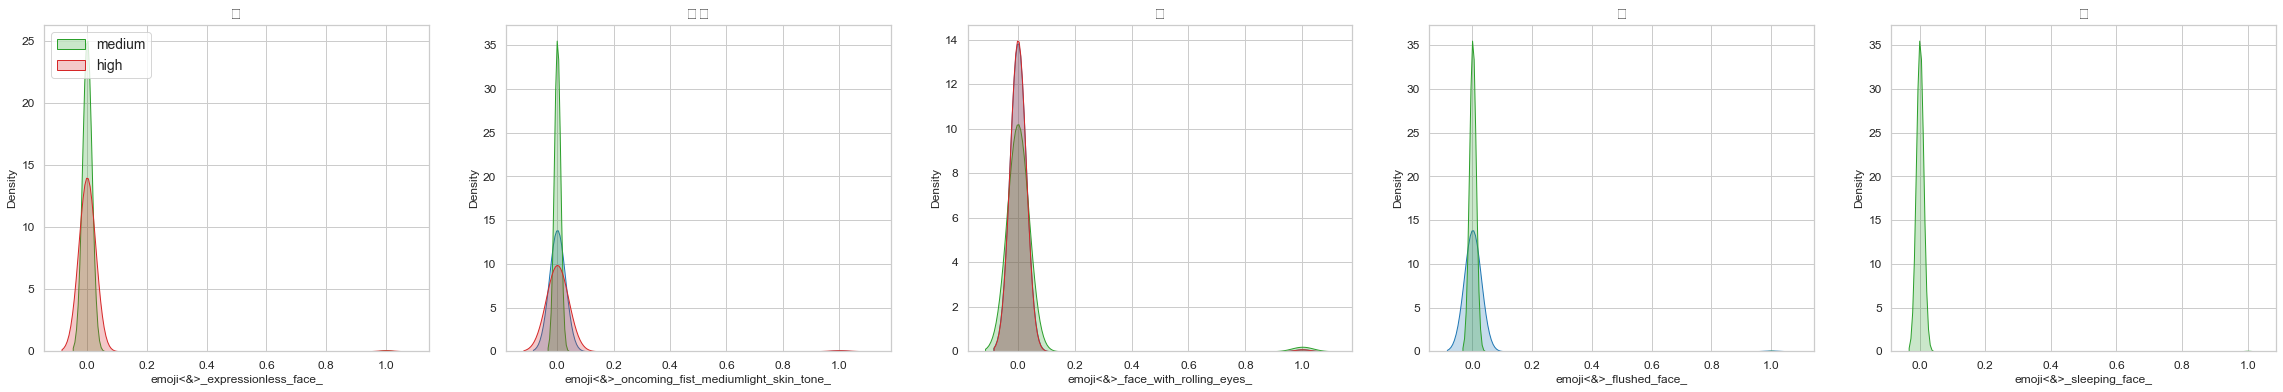

In [310]:
explorer = partition_attrib["emoji"][12:12+5]
colors_int = {"low": "tab:blue", "high": "tab:red", "medium": "tab:green"}
fig, ax = plt.subplots(1, len(explorer), figsize=(len(explorer)*8, 1*6))
for k, col in enumerate(explorer):      
    axi = ax[k]
    for int_ in intensities:
        _sub = df_representation[(df_train["sen"] == sen) & (df_train["int"] == int_)]
        sns.distplot(_sub[col], ax=axi , hist=False, kde_kws={"shade": True, "label": int_}, color=colors_int[int_])
        if "emoji<&>" in col:
            print(emojilib.emojize(col.replace("emoji<&>", "")))
            axi.set_title(emojilib.emojize(col.replace("emoji<&>", "")))
    if k == 0:
        axi.legend(loc='upper left')

In [294]:
emojilib.emojize("_hugging_face_")

'🤗'

In [313]:
df_describe_cols = df_representation.describe().T

In [323]:
df_describe_cols.shape

(11750, 8)

In [339]:
rel_cols = list(df_describe_cols[df_describe_cols["std"]>[0.0762, 0.0710, 0.0635, 0.0573, 0.0527, 0.0503, 0.0477, 0.0390, 0.0318, 0.0276, 0.0225, 0.0159][0]].index)

In [350]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [391]:
indexs = df_train[df_train["sen"] == sentiments[3]].index
X = df_representation.loc[indexs][rel_cols]
y = df_train.loc[X.index]["int"]

In [392]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', class_weight="balanced"))
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [408]:
from sklearn.feature_selection import SelectKBest, chi2

In [420]:
indexs = df_train[df_train["sen"] == sentiments[3]].index
indexsLH = df_train.loc[indexs][(df_train.loc[indexs]["int"].isin(["low", "high"]))].index

X = df_representation.loc[indexsLH]#[rel_cols]
y = df_train.loc[X.index]["int"]

dic_label_count = y.value_counts().to_dict()
min_label = min(dic_label_count.items(), key=lambda x: x[1])[0]
max_label = max(dic_label_count.items(), key=lambda x: x[1])[0]
index_label_1 = y[y==min_label].index
oversampling_steps = int(dic_label_count[max_label] / dic_label_count[min_label]) - 1
X_res, y_res = X.copy(), y.copy()

for step in range(oversampling_steps):
    new_indexs = [f"{ix}+{step + 1}" for ix in index_label_1]
    copied_sub_X = pd.DataFrame(X.loc[index_label_1].values, columns=X.columns, index=new_indexs)
    copied_sub_y = pd.Series(y.loc[index_label_1].values, index=new_indexs)
    X_res = pd.concat([X_res, copied_sub_X], axis=0)
    y_res = pd.concat([y_res, copied_sub_y], axis=0)

X_res = pd.DataFrame(StandardScaler().fit_transform(X_res), columns=X_res.columns, index=X_res.index)
selector = SelectKBest(chi2, k=X.shape[1])
X_res_ = X_res - X_res.min()
selector.fit(X_res_, y_res)
scores_selector = {col: selector.scores_[i] if str(selector.scores_[i]) != "nan" else 0 for i, col in enumerate(X.columns.tolist())}
ranked_cols = [x[0] for x in sorted(scores_selector.items(), key=lambda x: x[1], reverse=True)]
ranked_cols


['linguistics<&>lemma<&>depression',
 'linguistics<&>lemma<&>depress',
 'linguistics<&>lemma<&>sadness',
 'linguistics<&>lemma<&>bad',
 'linguistics<&>lemma<&>sad',
 'linguistics<&>lemma<&>depressing',
 'linguistics<&>lemma<&>serious',
 'linguistics<&>lemma<&>feel',
 'linguistics<&>lemma<&>unhappy',
 'linguistics<&>lemma<&>pine',
 'linguistics<&>lemma<&>sober',
 'linguistics<&>lemma<&>dull',
 'linguistics<&>lemma<&>blue',
 'emoji<&>_loudly_crying_face_',
 'linguistics<&>tag<&>RBS',
 'linguistics<&>lemma<&>hard',
 'linguistics<&>lemma<&>grim',
 'linguistics<&>lemma<&>frown',
 'linguistics<&>lemma<&>service',
 'linguistics<&>lemma<&>😭',
 'linguistics<&>shape<&>😭',
 'linguistics<&>lemma<&>despair',
 'linguistics<&>lemma<&>️',
 'linguistics<&>shape<&>️',
 'linguistics<&>lemma<&>ever',
 'linguistics<&>lemma<&>fucking',
 'linguistics<&>lemma<&>sadly',
 'linguistics<&>lemma<&>dishearten',
 'linguistics<&>lemma<&>fan',
 'linguistics<&>lemma<&>fret',
 'linguistics<&>lemma<&>guy',
 'linguistics<

In [457]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support

In [490]:
sen = sentiments[3]

indexs = df_train[df_train["sen"] == sen].index
indexsLH = df_train.loc[indexs][(df_train.loc[indexs]["int"].isin(["low", "high"]))].index

X = df_representation.loc[indexsLH]#[rel_cols]
y = df_train.loc[X.index]["int"]

dic_label_count = y.value_counts().to_dict()
min_label = min(dic_label_count.items(), key=lambda x: x[1])[0]
max_label = max(dic_label_count.items(), key=lambda x: x[1])[0]
index_label_1 = y[y==min_label].index
oversampling_steps = int(dic_label_count[max_label] / dic_label_count[min_label]) - 1
X_res, y_res = X.copy(), y.copy()

for step in range(oversampling_steps):
    new_indexs = [f"{ix}+{step + 1}" for ix in index_label_1]
    copied_sub_X = pd.DataFrame(X.loc[index_label_1].values, columns=X.columns, index=new_indexs)
    copied_sub_y = pd.Series(y.loc[index_label_1].values, index=new_indexs)
    X_res = pd.concat([X_res, copied_sub_X], axis=0)
    y_res = pd.concat([y_res, copied_sub_y], axis=0)

X_res = pd.DataFrame(StandardScaler().fit_transform(X_res), columns=X_res.columns, index=X_res.index)
selector = SelectKBest(chi2, k=X.shape[1])
X_res_ = X_res - X_res.min()
selector.fit(X_res_, y_res)
scores_selector = {col: selector.scores_[i] if str(selector.scores_[i]) != "nan" else 0 for i, col in enumerate(X.columns.tolist())}
ranked_cols = [x[0] for x in sorted(scores_selector.items(), key=lambda x: x[1], reverse=True)]
ranked_cols


f1_weight = []

for num_cols in range(1, len(ranked_cols), 10):
    X = df_representation.loc[indexs][ranked_cols[:num_cols+1]]
    y = df_train.loc[X.index]["int"]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto', class_weight="balanced"))
    # clf.fit(X_train, y_train)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="f1_weighted")
    test_score = cv_results["test_score"]
    f1_weight.append([num_cols, np.mean(test_score), np.std(test_score)])
    print(f1_weight[-1])

[1, 0.17764500176218634, 0.04267409206149184]
[11, 0.3024626291701063, 0.11194946412399774]
[21, 0.3789822004596333, 0.12318989310995017]
[31, 0.3701253003455773, 0.11069502685570087]
[41, 0.5140830478624945, 0.017767922025634833]
[51, 0.5342248667751726, 0.03551424167580498]
[61, 0.5491272393246589, 0.030019183298879884]
[71, 0.5457643682281283, 0.03447586913309776]
[81, 0.5489638582045673, 0.03671751504099164]
[91, 0.5520267521245351, 0.0369083094955541]
[101, 0.5483413541151839, 0.03554506473054729]
[111, 0.5406813100478531, 0.03556012609921711]
[121, 0.545480283305222, 0.025609896525082942]
[131, 0.5430986284055243, 0.02283672535416118]
[141, 0.5497817170239718, 0.020301535161532727]
[151, 0.5466863699520738, 0.021681248098248722]
[161, 0.5498641938086111, 0.024186356456579877]
[171, 0.5504741999475588, 0.02943339321641828]
[181, 0.541437834710182, 0.026221993648884345]
[191, 0.5426160508667537, 0.03308127191841251]
[201, 0.5472075820086931, 0.03797134153686845]
[211, 0.54852956744

KeyboardInterrupt: 

In [491]:
best_f1 = sorted(f1_weight, key=lambda x: x[1], reverse=True)[0][0]
best_f1

411

In [492]:
fine_f1_weight = []

for num_cols in range(best_f1-10, best_f1+10, 1):
    X = df_representation.loc[indexs][ranked_cols[:num_cols+1]]
    y = df_train.loc[X.index]["int"]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto', class_weight="balanced"))
    # clf.fit(X_train, y_train)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="f1_weighted")
    test_score = cv_results["test_score"]
    fine_f1_weight.append([num_cols, np.mean(test_score), np.std(test_score)])
    print(fine_f1_weight[-1])

[401, 0.570114121731599, 0.05907171316101098]
[402, 0.5712222690419162, 0.05923443886487164]
[403, 0.5725630121704057, 0.05995403527922426]
[404, 0.5739216678031865, 0.05837815516438582]
[405, 0.5748030859662495, 0.05745062043931183]
[406, 0.5748030859662495, 0.05745062043931183]
[407, 0.5752528637574006, 0.05942996348227247]
[408, 0.5764656712182863, 0.060260561111525085]
[409, 0.5776576842811842, 0.06106224580367734]
[410, 0.5754051067666254, 0.060563936265593706]
[411, 0.5766974194155757, 0.06076214922222044]
[412, 0.5753265314269608, 0.0596831636912677]
[413, 0.5764329741509286, 0.0599693219218823]
[414, 0.5763298330915798, 0.059542580170901666]
[415, 0.5763298330915798, 0.059542580170901666]
[416, 0.5763298330915798, 0.059542580170901666]
[417, 0.5763298330915798, 0.059542580170901666]
[418, 0.5749267655920647, 0.061409203480120626]
[419, 0.5763298330915798, 0.059542580170901666]
[420, 0.5763298330915798, 0.059542580170901666]


In [494]:
fine_best_f1 = sorted(fine_f1_weight, key=lambda x: x[1], reverse=True)[0][0]
fine_best_f1

409

In [495]:
pickle.dump(ranked_cols[:fine_best_f1+1], open(f"cols_selected_{sen}_v1.pickle", "wb"))

In [499]:
!pip install torchvision

  Using cached torch-1.11.0-cp38-cp38-win_amd64.whl (158.0 MB)


In [501]:
!pip install transformers

In [576]:
import torch
from transformers import AutoModel, AutoTokenizer

bertweet = AutoModel.from_pretrained("vinai/bertweet-base")

# For transformers v4.x+:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, normalization=True)

# For transformers v3.x:
# tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")


emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [592]:
data_bertweet = []
col_names = [f"BERTweet_{i}" for i in range(768)]
for k, ix in enumerate(df_train.index):
    print(k+1, df_train.shape[0], 100*(k+1)/df_train.shape[0])
    tweet = df_train.loc[ix]["text"]
    input_ids = torch.tensor([tokenizer.encode(tweet)])
    with torch.no_grad():
        outputs = bertweet(input_ids)
        hidden_states = outputs[0]

    token_embeddings = np.array([ll.numpy() for ll in hidden_states[0]])
    sentence_embedding = np.mean(token_embeddings, axis=0)
    o = {"id": ix}
    o = {**o, **dict(zip(col_names, sentence_embedding))}
    data_bertweet.append(o)

1 3960 0.025252525252525252
2 3960 0.050505050505050504
3 3960 0.07575757575757576
4 3960 0.10101010101010101
5 3960 0.12626262626262627
6 3960 0.15151515151515152
7 3960 0.17676767676767677
8 3960 0.20202020202020202
9 3960 0.22727272727272727
10 3960 0.25252525252525254
11 3960 0.2777777777777778
12 3960 0.30303030303030304
13 3960 0.3282828282828283
14 3960 0.35353535353535354
15 3960 0.3787878787878788
16 3960 0.40404040404040403
17 3960 0.4292929292929293
18 3960 0.45454545454545453
19 3960 0.4797979797979798
20 3960 0.5050505050505051
21 3960 0.5303030303030303
22 3960 0.5555555555555556
23 3960 0.5808080808080808
24 3960 0.6060606060606061
25 3960 0.6313131313131313
26 3960 0.6565656565656566
27 3960 0.6818181818181818
28 3960 0.7070707070707071
29 3960 0.7323232323232324
30 3960 0.7575757575757576
31 3960 0.7828282828282829
32 3960 0.8080808080808081
33 3960 0.8333333333333334
34 3960 0.8585858585858586
35 3960 0.8838383838383839
36 3960 0.9090909090909091
37 3960 0.93434343434

309 3960 7.803030303030303
310 3960 7.828282828282828
311 3960 7.853535353535354
312 3960 7.878787878787879
313 3960 7.904040404040404
314 3960 7.929292929292929
315 3960 7.954545454545454
316 3960 7.97979797979798
317 3960 8.005050505050505
318 3960 8.030303030303031
319 3960 8.055555555555555
320 3960 8.080808080808081
321 3960 8.106060606060606
322 3960 8.131313131313131
323 3960 8.156565656565656
324 3960 8.181818181818182
325 3960 8.207070707070708
326 3960 8.232323232323232
327 3960 8.257575757575758
328 3960 8.282828282828282
329 3960 8.308080808080808
330 3960 8.333333333333334
331 3960 8.358585858585858
332 3960 8.383838383838384
333 3960 8.409090909090908
334 3960 8.434343434343434
335 3960 8.45959595959596
336 3960 8.484848484848484
337 3960 8.51010101010101
338 3960 8.535353535353535
339 3960 8.56060606060606
340 3960 8.585858585858587
341 3960 8.61111111111111
342 3960 8.636363636363637
343 3960 8.66161616161616
344 3960 8.686868686868687
345 3960 8.712121212121213
346 396

610 3960 15.404040404040405
611 3960 15.429292929292929
612 3960 15.454545454545455
613 3960 15.47979797979798
614 3960 15.505050505050505
615 3960 15.530303030303031
616 3960 15.555555555555555
617 3960 15.580808080808081
618 3960 15.606060606060606
619 3960 15.631313131313131
620 3960 15.656565656565656
621 3960 15.681818181818182
622 3960 15.707070707070708
623 3960 15.732323232323232
624 3960 15.757575757575758
625 3960 15.782828282828282
626 3960 15.808080808080808
627 3960 15.833333333333334
628 3960 15.858585858585858
629 3960 15.883838383838384
630 3960 15.909090909090908
631 3960 15.934343434343434
632 3960 15.95959595959596
633 3960 15.984848484848484
634 3960 16.01010101010101
635 3960 16.035353535353536
636 3960 16.060606060606062
637 3960 16.085858585858585
638 3960 16.11111111111111
639 3960 16.136363636363637
640 3960 16.161616161616163
641 3960 16.18686868686869
642 3960 16.21212121212121
643 3960 16.237373737373737
644 3960 16.262626262626263
645 3960 16.28787878787879

909 3960 22.954545454545453
910 3960 22.97979797979798
911 3960 23.005050505050505
912 3960 23.03030303030303
913 3960 23.055555555555557
914 3960 23.08080808080808
915 3960 23.106060606060606
916 3960 23.13131313131313
917 3960 23.156565656565657
918 3960 23.181818181818183
919 3960 23.207070707070706
920 3960 23.232323232323232
921 3960 23.257575757575758
922 3960 23.282828282828284
923 3960 23.30808080808081
924 3960 23.333333333333332
925 3960 23.358585858585858
926 3960 23.383838383838384
927 3960 23.40909090909091
928 3960 23.434343434343436
929 3960 23.45959595959596
930 3960 23.484848484848484
931 3960 23.51010101010101
932 3960 23.535353535353536
933 3960 23.560606060606062
934 3960 23.585858585858585
935 3960 23.61111111111111
936 3960 23.636363636363637
937 3960 23.661616161616163
938 3960 23.68686868686869
939 3960 23.71212121212121
940 3960 23.737373737373737
941 3960 23.762626262626263
942 3960 23.78787878787879
943 3960 23.81313131313131
944 3960 23.838383838383837
945 3

1200 3960 30.303030303030305
1201 3960 30.328282828282827
1202 3960 30.353535353535353
1203 3960 30.37878787878788
1204 3960 30.404040404040405
1205 3960 30.42929292929293
1206 3960 30.454545454545453
1207 3960 30.47979797979798
1208 3960 30.505050505050505
1209 3960 30.53030303030303
1210 3960 30.555555555555557
1211 3960 30.58080808080808
1212 3960 30.606060606060606
1213 3960 30.63131313131313
1214 3960 30.656565656565657
1215 3960 30.681818181818183
1216 3960 30.707070707070706
1217 3960 30.732323232323232
1218 3960 30.757575757575758
1219 3960 30.782828282828284
1220 3960 30.80808080808081
1221 3960 30.833333333333332
1222 3960 30.858585858585858
1223 3960 30.883838383838384
1224 3960 30.90909090909091
1225 3960 30.934343434343436
1226 3960 30.95959595959596
1227 3960 30.984848484848484
1228 3960 31.01010101010101
1229 3960 31.035353535353536
1230 3960 31.060606060606062
1231 3960 31.085858585858585
1232 3960 31.11111111111111
1233 3960 31.136363636363637
1234 3960 31.161616161616

1495 3960 37.75252525252525
1496 3960 37.77777777777778
1497 3960 37.803030303030305
1498 3960 37.82828282828283
1499 3960 37.85353535353536
1500 3960 37.878787878787875
1501 3960 37.9040404040404
1502 3960 37.92929292929293
1503 3960 37.95454545454545
1504 3960 37.97979797979798
1505 3960 38.005050505050505
1506 3960 38.03030303030303
1507 3960 38.05555555555556
1508 3960 38.08080808080808
1509 3960 38.10606060606061
1510 3960 38.13131313131313
1511 3960 38.156565656565654
1512 3960 38.18181818181818
1513 3960 38.207070707070706
1514 3960 38.23232323232323
1515 3960 38.25757575757576
1516 3960 38.282828282828284
1517 3960 38.30808080808081
1518 3960 38.333333333333336
1519 3960 38.35858585858586
1520 3960 38.38383838383838
1521 3960 38.40909090909091
1522 3960 38.43434343434343
1523 3960 38.45959595959596
1524 3960 38.484848484848484
1525 3960 38.51010101010101
1526 3960 38.535353535353536
1527 3960 38.56060606060606
1528 3960 38.58585858585859
1529 3960 38.611111111111114
1530 3960 3

1790 3960 45.2020202020202
1791 3960 45.22727272727273
1792 3960 45.25252525252525
1793 3960 45.27777777777778
1794 3960 45.303030303030305
1795 3960 45.32828282828283
1796 3960 45.35353535353536
1797 3960 45.378787878787875
1798 3960 45.4040404040404
1799 3960 45.42929292929293
1800 3960 45.45454545454545
1801 3960 45.47979797979798
1802 3960 45.505050505050505
1803 3960 45.53030303030303
1804 3960 45.55555555555556
1805 3960 45.58080808080808
1806 3960 45.60606060606061
1807 3960 45.63131313131313
1808 3960 45.656565656565654
1809 3960 45.68181818181818
1810 3960 45.707070707070706
1811 3960 45.73232323232323
1812 3960 45.75757575757576
1813 3960 45.782828282828284
1814 3960 45.80808080808081
1815 3960 45.833333333333336
1816 3960 45.85858585858586
1817 3960 45.88383838383838
1818 3960 45.90909090909091
1819 3960 45.93434343434343
1820 3960 45.95959595959596
1821 3960 45.984848484848484
1822 3960 46.01010101010101
1823 3960 46.035353535353536
1824 3960 46.06060606060606
1825 3960 46.

2083 3960 52.601010101010104
2084 3960 52.62626262626262
2085 3960 52.65151515151515
2086 3960 52.676767676767675
2087 3960 52.7020202020202
2088 3960 52.72727272727273
2089 3960 52.75252525252525
2090 3960 52.77777777777778
2091 3960 52.803030303030305
2092 3960 52.82828282828283
2093 3960 52.85353535353536
2094 3960 52.878787878787875
2095 3960 52.9040404040404
2096 3960 52.92929292929293
2097 3960 52.95454545454545
2098 3960 52.97979797979798
2099 3960 53.005050505050505
2100 3960 53.03030303030303
2101 3960 53.05555555555556
2102 3960 53.08080808080808
2103 3960 53.10606060606061
2104 3960 53.13131313131313
2105 3960 53.156565656565654
2106 3960 53.18181818181818
2107 3960 53.207070707070706
2108 3960 53.23232323232323
2109 3960 53.25757575757576
2110 3960 53.282828282828284
2111 3960 53.30808080808081
2112 3960 53.333333333333336
2113 3960 53.35858585858586
2114 3960 53.38383838383838
2115 3960 53.40909090909091
2116 3960 53.43434343434343
2117 3960 53.45959595959596
2118 3960 53.

2377 3960 60.025252525252526
2378 3960 60.05050505050505
2379 3960 60.07575757575758
2380 3960 60.101010101010104
2381 3960 60.12626262626262
2382 3960 60.15151515151515
2383 3960 60.176767676767675
2384 3960 60.2020202020202
2385 3960 60.22727272727273
2386 3960 60.25252525252525
2387 3960 60.27777777777778
2388 3960 60.303030303030305
2389 3960 60.32828282828283
2390 3960 60.35353535353536
2391 3960 60.378787878787875
2392 3960 60.4040404040404
2393 3960 60.42929292929293
2394 3960 60.45454545454545
2395 3960 60.47979797979798
2396 3960 60.505050505050505
2397 3960 60.53030303030303
2398 3960 60.55555555555556
2399 3960 60.58080808080808
2400 3960 60.60606060606061
2401 3960 60.63131313131313
2402 3960 60.656565656565654
2403 3960 60.68181818181818
2404 3960 60.707070707070706
2405 3960 60.73232323232323
2406 3960 60.75757575757576
2407 3960 60.782828282828284
2408 3960 60.80808080808081
2409 3960 60.833333333333336
2410 3960 60.85858585858586
2411 3960 60.88383838383838
2412 3960 60

2672 3960 67.47474747474747
2673 3960 67.5
2674 3960 67.52525252525253
2675 3960 67.55050505050505
2676 3960 67.57575757575758
2677 3960 67.6010101010101
2678 3960 67.62626262626263
2679 3960 67.65151515151516
2680 3960 67.67676767676768
2681 3960 67.70202020202021
2682 3960 67.72727272727273
2683 3960 67.75252525252525
2684 3960 67.77777777777777
2685 3960 67.8030303030303
2686 3960 67.82828282828282
2687 3960 67.85353535353535
2688 3960 67.87878787878788
2689 3960 67.9040404040404
2690 3960 67.92929292929293
2691 3960 67.95454545454545
2692 3960 67.97979797979798
2693 3960 68.0050505050505
2694 3960 68.03030303030303
2695 3960 68.05555555555556
2696 3960 68.08080808080808
2697 3960 68.10606060606061
2698 3960 68.13131313131314
2699 3960 68.15656565656566
2700 3960 68.18181818181819
2701 3960 68.20707070707071
2702 3960 68.23232323232324
2703 3960 68.25757575757575
2704 3960 68.28282828282828
2705 3960 68.3080808080808
2706 3960 68.33333333333333
2707 3960 68.35858585858585
2708 3960 

2969 3960 74.97474747474747
2970 3960 75.0
2971 3960 75.02525252525253
2972 3960 75.05050505050505
2973 3960 75.07575757575758
2974 3960 75.1010101010101
2975 3960 75.12626262626263
2976 3960 75.15151515151516
2977 3960 75.17676767676768
2978 3960 75.20202020202021
2979 3960 75.22727272727273
2980 3960 75.25252525252525
2981 3960 75.27777777777777
2982 3960 75.3030303030303
2983 3960 75.32828282828282
2984 3960 75.35353535353535
2985 3960 75.37878787878788
2986 3960 75.4040404040404
2987 3960 75.42929292929293
2988 3960 75.45454545454545
2989 3960 75.47979797979798
2990 3960 75.5050505050505
2991 3960 75.53030303030303
2992 3960 75.55555555555556
2993 3960 75.58080808080808
2994 3960 75.60606060606061
2995 3960 75.63131313131314
2996 3960 75.65656565656566
2997 3960 75.68181818181819
2998 3960 75.70707070707071
2999 3960 75.73232323232324
3000 3960 75.75757575757575
3001 3960 75.78282828282828
3002 3960 75.8080808080808
3003 3960 75.83333333333333
3004 3960 75.85858585858585
3005 3960 

3266 3960 82.47474747474747
3267 3960 82.5
3268 3960 82.52525252525253
3269 3960 82.55050505050505
3270 3960 82.57575757575758
3271 3960 82.6010101010101
3272 3960 82.62626262626263
3273 3960 82.65151515151516
3274 3960 82.67676767676768
3275 3960 82.70202020202021
3276 3960 82.72727272727273
3277 3960 82.75252525252525
3278 3960 82.77777777777777
3279 3960 82.8030303030303
3280 3960 82.82828282828282
3281 3960 82.85353535353535
3282 3960 82.87878787878788
3283 3960 82.9040404040404
3284 3960 82.92929292929293
3285 3960 82.95454545454545
3286 3960 82.97979797979798
3287 3960 83.0050505050505
3288 3960 83.03030303030303
3289 3960 83.05555555555556
3290 3960 83.08080808080808
3291 3960 83.10606060606061
3292 3960 83.13131313131314
3293 3960 83.15656565656566
3294 3960 83.18181818181819
3295 3960 83.20707070707071
3296 3960 83.23232323232324
3297 3960 83.25757575757575
3298 3960 83.28282828282828
3299 3960 83.3080808080808
3300 3960 83.33333333333333
3301 3960 83.35858585858585
3302 3960 

3564 3960 90.0
3565 3960 90.02525252525253
3566 3960 90.05050505050505
3567 3960 90.07575757575758
3568 3960 90.1010101010101
3569 3960 90.12626262626263
3570 3960 90.15151515151516
3571 3960 90.17676767676768
3572 3960 90.20202020202021
3573 3960 90.22727272727273
3574 3960 90.25252525252525
3575 3960 90.27777777777777
3576 3960 90.3030303030303
3577 3960 90.32828282828282
3578 3960 90.35353535353535
3579 3960 90.37878787878788
3580 3960 90.4040404040404
3581 3960 90.42929292929293
3582 3960 90.45454545454545
3583 3960 90.47979797979798
3584 3960 90.5050505050505
3585 3960 90.53030303030303
3586 3960 90.55555555555556
3587 3960 90.58080808080808
3588 3960 90.60606060606061
3589 3960 90.63131313131314
3590 3960 90.65656565656566
3591 3960 90.68181818181819
3592 3960 90.70707070707071
3593 3960 90.73232323232324
3594 3960 90.75757575757575
3595 3960 90.78282828282828
3596 3960 90.8080808080808
3597 3960 90.83333333333333
3598 3960 90.85858585858585
3599 3960 90.88383838383838
3600 3960 

3860 3960 97.47474747474747
3861 3960 97.5
3862 3960 97.52525252525253
3863 3960 97.55050505050505
3864 3960 97.57575757575758
3865 3960 97.6010101010101
3866 3960 97.62626262626263
3867 3960 97.65151515151516
3868 3960 97.67676767676768
3869 3960 97.70202020202021
3870 3960 97.72727272727273
3871 3960 97.75252525252525
3872 3960 97.77777777777777
3873 3960 97.8030303030303
3874 3960 97.82828282828282
3875 3960 97.85353535353535
3876 3960 97.87878787878788
3877 3960 97.9040404040404
3878 3960 97.92929292929293
3879 3960 97.95454545454545
3880 3960 97.97979797979798
3881 3960 98.0050505050505
3882 3960 98.03030303030303
3883 3960 98.05555555555556
3884 3960 98.08080808080808
3885 3960 98.10606060606061
3886 3960 98.13131313131314
3887 3960 98.15656565656566
3888 3960 98.18181818181819
3889 3960 98.20707070707071
3890 3960 98.23232323232324
3891 3960 98.25757575757575
3892 3960 98.28282828282828
3893 3960 98.3080808080808
3894 3960 98.33333333333333
3895 3960 98.35858585858585
3896 3960 

In [593]:
pickle.dump(pd.DataFrame(data_bertweet).set_index("id"), open("df_representation_v2.pickle", "wb"))

In [594]:
df_representation_v2 = pickle.load(open("df_representation_v2.pickle", "rb"))

In [595]:
df_representation_v2

,BERTweet_0,BERTweet_1,BERTweet_2,BERTweet_3,BERTweet_4,BERTweet_5,BERTweet_6,BERTweet_7,BERTweet_8,BERTweet_9,...,BERTweet_758,BERTweet_759,BERTweet_760,BERTweet_761,BERTweet_762,BERTweet_763,BERTweet_764,BERTweet_765,BERTweet_766,BERTweet_767
id,,,,,,,,,,,,,,,,,,,,,
10000,0.011935,-0.122075,0.029030,0.120095,0.093651,0.022820,0.006946,0.168774,0.282526,-0.009636,...,0.091612,0.013699,0.048113,0.180316,0.025295,-0.094723,0.094302,-0.039285,0.234481,-0.249347
10001,0.019873,-0.154840,0.128666,-0.013688,0.124787,-0.060633,0.029985,0.192368,0.358541,-0.000735,...,0.061139,0.057788,0.016066,0.114631,-0.075937,0.161129,0.088782,0.099523,0.195573,-0.094360
10002,0.089303,0.005199,0.056339,0.029113,0.114146,0.105520,0.041722,0.180096,0.075384,0.047837,...,0.058741,-0.221301,0.011673,0.277279,0.015945,0.010225,0.090561,0.177221,0.102671,-0.183728
10003,-0.174818,-0.169233,0.108006,0.089053,0.113685,-0.024810,0.045306,0.109823,0.190615,-0.004136,...,0.041260,0.074323,0.122148,0.129413,0.010133,-0.035607,0.095457,0.020883,0.222822,-0.049975
10004,0.016567,-0.013723,0.086389,-0.020837,0.122210,0.105154,0.083129,0.222264,0.327119,0.121932,...,0.152741,-0.128246,0.041543,0.219807,0.010124,0.019276,0.062688,0.044342,0.058079,-0.121317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40855,0.025625,-0.161436,0.085601,0.067647,0.092613,0.041396,0.085973,0.192643,0.252361,-0.007928,...,0.094263,0.087653,-0.054003,-0.014100,-0.015075,0.043808,0.258219,-0.013177,0.014293,0.006944
40856,-0.107447,0.002433,0.046188,0.105640,0.028643,0.141425,-0.002773,0.256521,0.372382,0.066727,...,0.090047,-0.136675,-0.018746,-0.072087,0.148523,-0.059273,0.200686,0.004628,0.182843,-0.168076
40857,-0.043438,0.011180,0.206375,0.071783,0.163780,-0.062001,-0.111886,0.200515,0.215893,0.117610,...,0.214575,-0.152968,-0.036713,0.054679,-0.097778,-0.037324,0.141307,0.059210,0.080930,-0.205299


In [613]:
sen = sentiments[3]

indexs = df_train[df_train["sen"] == sen].index
indexsLH = df_train.loc[indexs][(df_train.loc[indexs]["int"].isin(["low", "high"]))].index

X = df_representation_v2.loc[indexsLH]#[rel_cols]
y = df_train.loc[X.index]["int"]

dic_label_count = y.value_counts().to_dict()
min_label = min(dic_label_count.items(), key=lambda x: x[1])[0]
max_label = max(dic_label_count.items(), key=lambda x: x[1])[0]
index_label_1 = y[y==min_label].index
oversampling_steps = int(dic_label_count[max_label] / dic_label_count[min_label]) - 1

X_res, y_res = X.copy(), y.copy()
for step in range(oversampling_steps):
    new_indexs = [f"{ix}+{step + 1}" for ix in index_label_1]
    copied_sub_X = pd.DataFrame(X.loc[index_label_1].values, columns=X.columns, index=new_indexs)
    copied_sub_y = pd.Series(y.loc[index_label_1].values, index=new_indexs)
    X_res = pd.concat([X_res, copied_sub_X], axis=0)
    y_res = pd.concat([y_res, copied_sub_y], axis=0)

X_res = pd.DataFrame(StandardScaler().fit_transform(X_res), columns=X_res.columns, index=X_res.index)
selector = SelectKBest(chi2, k=X.shape[1])
X_res_ = X_res - X_res.min()
selector.fit(X_res_, y_res)
scores_selector = {col: selector.scores_[i] if str(selector.scores_[i]) != "nan" else 0 for i, col in enumerate(X.columns.tolist())}
ranked_cols = [x[0] for x in sorted(scores_selector.items(), key=lambda x: x[1], reverse=True)]
print(ranked_cols)

f1_weight = []

for num_cols in range(1, len(ranked_cols)+1, 10):
    X = df_representation_v2.loc[indexs][ranked_cols[:num_cols+1]]
    y = df_train.loc[X.index]["int"]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto', class_weight="balanced"))
    # clf.fit(X_train, y_train)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="f1_weighted")
    test_score = cv_results["test_score"]
    f1_weight.append([num_cols, np.mean(test_score), np.std(test_score)])
    print(f1_weight[-1])

['BERTweet_422', 'BERTweet_491', 'BERTweet_68', 'BERTweet_550', 'BERTweet_190', 'BERTweet_251', 'BERTweet_546', 'BERTweet_344', 'BERTweet_200', 'BERTweet_205', 'BERTweet_213', 'BERTweet_102', 'BERTweet_221', 'BERTweet_745', 'BERTweet_99', 'BERTweet_677', 'BERTweet_139', 'BERTweet_746', 'BERTweet_648', 'BERTweet_303', 'BERTweet_162', 'BERTweet_455', 'BERTweet_307', 'BERTweet_286', 'BERTweet_332', 'BERTweet_540', 'BERTweet_590', 'BERTweet_566', 'BERTweet_714', 'BERTweet_122', 'BERTweet_760', 'BERTweet_58', 'BERTweet_144', 'BERTweet_442', 'BERTweet_440', 'BERTweet_452', 'BERTweet_723', 'BERTweet_164', 'BERTweet_732', 'BERTweet_626', 'BERTweet_301', 'BERTweet_86', 'BERTweet_161', 'BERTweet_753', 'BERTweet_136', 'BERTweet_675', 'BERTweet_226', 'BERTweet_187', 'BERTweet_310', 'BERTweet_531', 'BERTweet_31', 'BERTweet_445', 'BERTweet_130', 'BERTweet_627', 'BERTweet_697', 'BERTweet_276', 'BERTweet_184', 'BERTweet_79', 'BERTweet_755', 'BERTweet_142', 'BERTweet_707', 'BERTweet_588', 'BERTweet_766

[1, 0.42526762847144806, 0.01708408372717207]
[11, 0.523759038606341, 0.03348429040490501]
[21, 0.5747636447637632, 0.06602933326941429]
[31, 0.576223254221679, 0.04766115157377913]
[41, 0.5808773517443296, 0.06388626326451052]
[51, 0.6090467545604787, 0.04696588688232197]
[61, 0.6081209998301078, 0.044473571761780614]
[71, 0.5982765784014975, 0.06347640473692785]
[81, 0.5868008695366169, 0.05969350639021546]
[91, 0.5858505240586893, 0.05143799274850169]
[101, 0.5914875629020632, 0.06022011685352232]
[111, 0.5917913603219469, 0.04710115388414654]
[121, 0.5956057058893638, 0.047567050981943804]
[131, 0.5923111938484314, 0.045337790613449946]
[141, 0.6042347259243508, 0.04268177776103945]
[151, 0.5929107201320485, 0.04616234066886808]
[161, 0.5950814142317332, 0.04183897491925079]
[171, 0.5865037723473224, 0.047702280963444116]
[181, 0.5899003095471291, 0.04400093312539821]
[191, 0.5880695086518672, 0.05615953140596373]
[201, 0.5966941314775722, 0.047280879419035846]
[211, 0.606476745692

In [614]:
best_f1 = sorted(f1_weight, key=lambda x: x[1], reverse=True)[0][0]
best_f1

411

In [615]:
fine_f1_weight = []

for num_cols in range(best_f1-10, best_f1+10, 1):
    X = df_representation_v2.loc[indexs][ranked_cols[:num_cols+1]]
    y = df_train.loc[X.index]["int"]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto', class_weight="balanced"))
    # clf.fit(X_train, y_train)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="f1_weighted")
    test_score = cv_results["test_score"]
    fine_f1_weight.append([num_cols, np.mean(test_score), np.std(test_score)])
    print(fine_f1_weight[-1])

[401, 0.6260232879350924, 0.04980420841408524]
[402, 0.6260232879350924, 0.04980420841408524]
[403, 0.6260232879350924, 0.04980420841408524]
[404, 0.6283425491517305, 0.04874116164664491]
[405, 0.6296290233579253, 0.04688143574556793]
[406, 0.6286699800029222, 0.04830895805472933]
[407, 0.6286319803098179, 0.047983079671125195]
[408, 0.6296821538402746, 0.0467536803984406]
[409, 0.6296821538402746, 0.0467536803984406]
[410, 0.6296821538402746, 0.0467536803984406]
[411, 0.6296579544159963, 0.04671499360793837]
[412, 0.6251670491899469, 0.04384903353107423]
[413, 0.6251670491899469, 0.04384903353107423]
[414, 0.6263376272562879, 0.04567871088941871]
[415, 0.6265167083347271, 0.044432151023578566]
[416, 0.6277412455315968, 0.047762393326056383]
[417, 0.6288149541120509, 0.04682118135950047]
[418, 0.6244563857169697, 0.04517239817305424]
[419, 0.6255300942974238, 0.04425580559325953]
[420, 0.626509218817694, 0.04459999122576923]


In [616]:
fine_best_f1 = sorted(fine_f1_weight, key=lambda x: x[1], reverse=True)[0][0]
fine_best_f1

408

In [618]:
pickle.dump(ranked_cols[:fine_best_f1+1], open(f"cols_selected_{sen}_v2.pickle", "wb"))

In [621]:
df_representation_v3 = df_representation
df_representation_v3 = pd.concat([df_representation_v3, df_representation_v2], axis=1)
df_representation_v3

,retro<&>num_tokens,retro<&>lenght,retro<&>num_numbs,retro<&>num_alpha,retro<&>num_with_uppercase,retro<&>num_tokens_upper,retro<&>prop_vowels,retro<&>len_max_rep_char,retro<&>max_char_fre_per_token(o),retro<&>max_char_fre_per_token(s),...,BERTweet_758,BERTweet_759,BERTweet_760,BERTweet_761,BERTweet_762,BERTweet_763,BERTweet_764,BERTweet_765,BERTweet_766,BERTweet_767
id,,,,,,,,,,,,,,,,,,,,,
10000,18,96,0,18,3,1,0.253165,2,2,1,...,0.091612,0.013699,0.048113,0.180316,0.025295,-0.094723,0.094302,-0.039285,0.234481,-0.249347
10001,23,119,0,25,7,2,0.329897,2,2,2,...,0.061139,0.057788,0.016066,0.114631,-0.075937,0.161129,0.088782,0.099523,0.195573,-0.094360
10002,19,108,0,19,2,2,0.333333,2,3,2,...,0.058741,-0.221301,0.011673,0.277279,0.015945,0.010225,0.090561,0.177221,0.102671,-0.183728
10003,24,134,0,23,1,1,0.315315,2,1,2,...,0.041260,0.074323,0.122148,0.129413,0.010133,-0.035607,0.095457,0.020883,0.222822,-0.049975
10004,24,125,0,25,3,0,0.352941,2,1,0,...,0.152741,-0.128246,0.041543,0.219807,0.010124,0.019276,0.062688,0.044342,0.058079,-0.121317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40855,24,112,0,23,2,1,0.325843,2,2,2,...,0.094263,0.087653,-0.054003,-0.014100,-0.015075,0.043808,0.258219,-0.013177,0.014293,0.006944
40856,20,121,0,21,1,0,0.352941,2,1,3,...,0.090047,-0.136675,-0.018746,-0.072087,0.148523,-0.059273,0.200686,0.004628,0.182843,-0.168076
40857,23,139,0,23,2,1,0.316239,2,2,4,...,0.214575,-0.152968,-0.036713,0.054679,-0.097778,-0.037324,0.141307,0.059210,0.080930,-0.205299


In [643]:
pickle.dump(df_representation_v3, open("df_representation_v3.pickle", "wb"))

In [656]:
sen = sentiments[3]

indexs = df_train[df_train["sen"] == sen].index
indexsLH = df_train.loc[indexs][(df_train.loc[indexs]["int"].isin(["low", "high"]))].index

X = df_representation_v3.loc[indexsLH]#[rel_cols]
y = df_train.loc[X.index]["int"]

dic_label_count = y.value_counts().to_dict()
min_label = min(dic_label_count.items(), key=lambda x: x[1])[0]
max_label = max(dic_label_count.items(), key=lambda x: x[1])[0]
index_label_1 = y[y==min_label].index
oversampling_steps = int(dic_label_count[max_label] / dic_label_count[min_label]) - 1

X_res, y_res = X.copy(), y.copy()
for step in range(oversampling_steps):
    new_indexs = [f"{ix}+{step + 1}" for ix in index_label_1]
    copied_sub_X = pd.DataFrame(X.loc[index_label_1].values, columns=X.columns, index=new_indexs)
    copied_sub_y = pd.Series(y.loc[index_label_1].values, index=new_indexs)
    X_res = pd.concat([X_res, copied_sub_X], axis=0)
    y_res = pd.concat([y_res, copied_sub_y], axis=0)

X_res = pd.DataFrame(StandardScaler().fit_transform(X_res), columns=X_res.columns, index=X_res.index)
selector = SelectKBest(chi2, k=X.shape[1])
X_res_ = X_res - X_res.min()
selector.fit(X_res_, y_res)
scores_selector = {col: selector.scores_[i] if str(selector.scores_[i]) != "nan" else 0 for i, col in enumerate(X.columns.tolist())}
ranked_cols = [x[0] for x in sorted(scores_selector.items(), key=lambda x: x[1], reverse=True)]
print(ranked_cols)

f1_weight = []

for num_cols in range(1, len(ranked_cols)+1, 10):
    X = df_representation_v3.loc[indexs][ranked_cols[:num_cols+1]]
    y = df_train.loc[X.index]["int"]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto', class_weight="balanced"))
    # clf.fit(X_train, y_train)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="f1_weighted")
    test_score = cv_results["test_score"]
    f1_weight.append([num_cols, np.mean(test_score), np.std(test_score)])
    print(f1_weight[-1])

['linguistics<&>lemma<&>depression', 'linguistics<&>lemma<&>depress', 'linguistics<&>lemma<&>sadness', 'linguistics<&>lemma<&>bad', 'linguistics<&>lemma<&>sad', 'linguistics<&>lemma<&>depressing', 'linguistics<&>lemma<&>serious', 'linguistics<&>lemma<&>feel', 'linguistics<&>lemma<&>unhappy', 'linguistics<&>lemma<&>pine', 'linguistics<&>lemma<&>sober', 'linguistics<&>lemma<&>dull', 'linguistics<&>lemma<&>blue', 'emoji<&>_loudly_crying_face_', 'linguistics<&>tag<&>RBS', 'linguistics<&>lemma<&>hard', 'linguistics<&>lemma<&>grim', 'linguistics<&>lemma<&>frown', 'linguistics<&>lemma<&>service', 'linguistics<&>lemma<&>😭', 'linguistics<&>shape<&>😭', 'linguistics<&>lemma<&>despair', 'linguistics<&>lemma<&>️', 'linguistics<&>shape<&>️', 'linguistics<&>lemma<&>ever', 'linguistics<&>lemma<&>fucking', 'linguistics<&>lemma<&>sadly', 'linguistics<&>lemma<&>dishearten', 'linguistics<&>lemma<&>fan', 'linguistics<&>lemma<&>fret', 'linguistics<&>lemma<&>guy', 'linguistics<&>lemma<&>into', 'linguistics<&

[11, 0.3024626291701063, 0.11194946412399774]
[21, 0.3789822004596333, 0.12318989310995017]
[31, 0.3701253003455773, 0.11069502685570087]
[41, 0.5140830478624945, 0.017767922025634833]
[51, 0.5342248667751726, 0.03551424167580498]
[61, 0.5491272393246589, 0.030019183298879884]
[71, 0.5457643682281283, 0.03447586913309776]
[81, 0.5489638582045673, 0.03671751504099164]
[91, 0.5520267521245351, 0.0369083094955541]
[101, 0.5483413541151839, 0.03554506473054729]
[111, 0.5406813100478531, 0.03556012609921711]
[121, 0.545480283305222, 0.025609896525082942]
[131, 0.5430986284055243, 0.02283672535416118]
[141, 0.5497817170239718, 0.020301535161532727]
[151, 0.5466863699520738, 0.021681248098248722]
[161, 0.5498641938086111, 0.024186356456579877]
[171, 0.5504741999475588, 0.02943339321641828]
[181, 0.541437834710182, 0.026221993648884345]
[191, 0.5426160508667537, 0.03308127191841251]
[201, 0.5472075820086931, 0.03797134153686845]
[211, 0.5485295674491542, 0.03109521831367633]
[221, 0.5680717802

KeyboardInterrupt: 

In [657]:
best_f1 = sorted(f1_weight, key=lambda x: x[1], reverse=True)[0][0]
best_f1

411

In [658]:
fine_f1_weight = []

for num_cols in range(best_f1-10, best_f1+10, 1):
    X = df_representation_v3.loc[indexs][ranked_cols[:num_cols+1]]
    y = df_train.loc[X.index]["int"]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto', class_weight="balanced"))
    # clf.fit(X_train, y_train)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="f1_weighted")
    test_score = cv_results["test_score"]
    fine_f1_weight.append([num_cols, np.mean(test_score), np.std(test_score)])
    print(fine_f1_weight[-1])

[401, 0.570114121731599, 0.05907171316101098]
[402, 0.5712222690419162, 0.05923443886487164]
[403, 0.5725630121704057, 0.05995403527922426]
[404, 0.5739216678031865, 0.05837815516438582]
[405, 0.5748030859662495, 0.05745062043931183]
[406, 0.5748030859662495, 0.05745062043931183]
[407, 0.5752528637574006, 0.05942996348227247]
[408, 0.5764656712182863, 0.060260561111525085]
[409, 0.5776576842811842, 0.06106224580367734]
[410, 0.5754051067666254, 0.060563936265593706]
[411, 0.5766974194155757, 0.06076214922222044]
[412, 0.5753265314269608, 0.0596831636912677]
[413, 0.5764329741509286, 0.0599693219218823]
[414, 0.5763298330915798, 0.059542580170901666]
[415, 0.5763298330915798, 0.059542580170901666]
[416, 0.5763298330915798, 0.059542580170901666]
[417, 0.5763298330915798, 0.059542580170901666]
[418, 0.5749267655920647, 0.061409203480120626]
[419, 0.5763298330915798, 0.059542580170901666]
[420, 0.5763298330915798, 0.059542580170901666]


In [659]:
fine_best_f1 = sorted(fine_f1_weight, key=lambda x: x[1], reverse=True)[0][0]
fine_best_f1

409

In [660]:
pickle.dump(ranked_cols[:fine_best_f1+1], open(f"cols_selected_{sen}_v3.pickle", "wb"))

In [694]:
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('opinion_lexicon')
# nltk.download("sentiwordnet")
# nltk.download('omw-1.4')

from nltk.corpus import opinion_lexicon
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [710]:
def get_sentiwordnet_sent(tweet):
    def penn_to_wn(tag):
        if tag.startswith('J'):
            return wn.ADJ
        elif tag.startswith('N'):
            return wn.NOUN
        elif tag.startswith('R'):
            return wn.ADV
        elif tag.startswith('V'):
            return wn.VERB
        return None

    def get_sentiment(word,tag):
        wn_tag = penn_to_wn(tag)
        if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
            return [0,0,0]

        lemma = lemmatizer.lemmatize(word, pos=wn_tag)
        if not lemma:
            return [0,0,0]

        synsets = wn.synsets(word, pos=wn_tag)
        if not synsets:
            return [0,0,0]

        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())

        return [swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

    words_data = tweet.lower().strip().split()

    pos_val = nltk.pos_tag(words_data)
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    return dict(zip("+ - o".split(), np.sum(senti_val, axis=0)))

In [662]:
print(f"Cantidad de palabras positivas: {len(opinion_lexicon.positive())}")
print(f"Cantidad de palabras negativas: {len(opinion_lexicon.negative())}")

Cantidad de palabras positivas: 2006
Cantidad de palabras positivas: 4783


In [712]:
def get_lexicon_attrib(tweet):
    o = {}
    o["lexicon<&>LiuHu<&>+"] = sum(int(t.lower() in opinion_lexicon.positive()) for t in tweet.split())
    o["lexicon<&>LiuHu<&>-"] = sum(int(t.lower() in opinion_lexicon.negative()) for t in tweet.split())
    o_sentiwordnet = get_sentiwordnet_sent(tweet)
    o["lexicon<&>sentiwordnet<&>+"] = o_sentiwordnet["+"]
    o["lexicon<&>sentiwordnet<&>-"] = o_sentiwordnet["-"]
    o["lexicon<&>sentiwordnet<&>o"] = o_sentiwordnet["o"]
    return o

In [713]:
get_lexicon_attrib(tweet)

{'lexicon<&>LiuHu<&>+': 0,
 'lexicon<&>LiuHu<&>-': 6,
 'lexicon<&>sentiwordnet<&>+': 0.375,
 'lexicon<&>sentiwordnet<&>-': 3.5,
 'lexicon<&>sentiwordnet<&>o': 3.125}

In [669]:
data_lexicon_attributes = []
times = []
for k, ix in enumerate(df_train.index):
    start_time = time.time()
    tweet = df_train.loc[ix]["text"]
    o = {"id": ix}
    o = {**o, **get_lexicon_attrib(tweet)}
    data_lexicon_attributes.append(o)
    dt = time.time()-start_time
    times.append(dt)
    print(f"""
    row: {k+1}, total_rows: {df_train.shape[0]}
    progress: {np.round(100*(k+1)/df_train.shape[0], 3)}%
    wait time: {datetime.timedelta(seconds = np.median(times)*(df_train.shape[0]-k-1))}s
    """)


    row: 1, total_rows: 3960
    progress: 0.025%
    wait time: 0:13:56.109647s
    

    row: 2, total_rows: 3960
    progress: 0.051%
    wait time: 0:15:50.783487s
    

    row: 3, total_rows: 3960
    progress: 0.076%
    wait time: 0:15:28.099567s
    

    row: 4, total_rows: 3960
    progress: 0.101%
    wait time: 0:16:15.050782s
    

    row: 5, total_rows: 3960
    progress: 0.126%
    wait time: 0:16:43.898985s
    

    row: 6, total_rows: 3960
    progress: 0.152%
    wait time: 0:14:27.372041s
    

    row: 7, total_rows: 3960
    progress: 0.177%
    wait time: 0:15:09.450331s
    

    row: 8, total_rows: 3960
    progress: 0.202%
    wait time: 0:15:23.135576s
    

    row: 9, total_rows: 3960
    progress: 0.227%
    wait time: 0:14:53.737124s
    

    row: 10, total_rows: 3960
    progress: 0.253%
    wait time: 0:14:44.022115s
    

    row: 11, total_rows: 3960
    progress: 0.278%
    wait time: 0:14:05.134906s
    

    row: 12, total_rows: 3960
    progre


    row: 95, total_rows: 3960
    progress: 2.399%
    wait time: 0:12:20.473808s
    

    row: 96, total_rows: 3960
    progress: 2.424%
    wait time: 0:12:23.408039s
    

    row: 97, total_rows: 3960
    progress: 2.449%
    wait time: 0:12:27.711201s
    

    row: 98, total_rows: 3960
    progress: 2.475%
    wait time: 0:12:29.593108s
    

    row: 99, total_rows: 3960
    progress: 2.5%
    wait time: 0:12:30.495198s
    

    row: 100, total_rows: 3960
    progress: 2.525%
    wait time: 0:12:25.540909s
    

    row: 101, total_rows: 3960
    progress: 2.551%
    wait time: 0:12:24.201626s
    

    row: 102, total_rows: 3960
    progress: 2.576%
    wait time: 0:12:22.923252s
    

    row: 103, total_rows: 3960
    progress: 2.601%
    wait time: 0:12:25.264672s
    

    row: 104, total_rows: 3960
    progress: 2.626%
    wait time: 0:12:23.102775s
    

    row: 105, total_rows: 3960
    progress: 2.652%
    wait time: 0:12:18.407062s
    

    row: 106, total_rows: 3


    row: 189, total_rows: 3960
    progress: 4.773%
    wait time: 0:12:04.059774s
    

    row: 190, total_rows: 3960
    progress: 4.798%
    wait time: 0:12:02.163114s
    

    row: 191, total_rows: 3960
    progress: 4.823%
    wait time: 0:12:03.682352s
    

    row: 192, total_rows: 3960
    progress: 4.848%
    wait time: 0:12:04.790017s
    

    row: 193, total_rows: 3960
    progress: 4.874%
    wait time: 0:12:02.660098s
    

    row: 194, total_rows: 3960
    progress: 4.899%
    wait time: 0:12:02.144447s
    

    row: 195, total_rows: 3960
    progress: 4.924%
    wait time: 0:12:00.492093s
    

    row: 196, total_rows: 3960
    progress: 4.949%
    wait time: 0:12:01.066073s
    

    row: 197, total_rows: 3960
    progress: 4.975%
    wait time: 0:12:01.497881s
    

    row: 198, total_rows: 3960
    progress: 5.0%
    wait time: 0:12:01.656797s
    

    row: 199, total_rows: 3960
    progress: 5.025%
    wait time: 0:12:03.665845s
    

    row: 200, total_ro


    row: 283, total_rows: 3960
    progress: 7.146%
    wait time: 0:11:49.317130s
    

    row: 284, total_rows: 3960
    progress: 7.172%
    wait time: 0:11:50.086412s
    

    row: 285, total_rows: 3960
    progress: 7.197%
    wait time: 0:11:49.738444s
    

    row: 286, total_rows: 3960
    progress: 7.222%
    wait time: 0:11:48.067297s
    

    row: 287, total_rows: 3960
    progress: 7.247%
    wait time: 0:11:48.303070s
    

    row: 288, total_rows: 3960
    progress: 7.273%
    wait time: 0:11:47.157382s
    

    row: 289, total_rows: 3960
    progress: 7.298%
    wait time: 0:11:48.269182s
    

    row: 290, total_rows: 3960
    progress: 7.323%
    wait time: 0:11:46.217272s
    

    row: 291, total_rows: 3960
    progress: 7.348%
    wait time: 0:11:46.665222s
    

    row: 292, total_rows: 3960
    progress: 7.374%
    wait time: 0:11:45.222480s
    

    row: 293, total_rows: 3960
    progress: 7.399%
    wait time: 0:11:46.100171s
    

    row: 294, total_


    row: 376, total_rows: 3960
    progress: 9.495%
    wait time: 0:11:23.973449s
    

    row: 377, total_rows: 3960
    progress: 9.52%
    wait time: 0:11:22.939135s
    

    row: 378, total_rows: 3960
    progress: 9.545%
    wait time: 0:11:23.531673s
    

    row: 379, total_rows: 3960
    progress: 9.571%
    wait time: 0:11:22.805092s
    

    row: 380, total_rows: 3960
    progress: 9.596%
    wait time: 0:11:22.977451s
    

    row: 381, total_rows: 3960
    progress: 9.621%
    wait time: 0:11:24.341773s
    

    row: 382, total_rows: 3960
    progress: 9.646%
    wait time: 0:11:23.278345s
    

    row: 383, total_rows: 3960
    progress: 9.672%
    wait time: 0:11:22.799527s
    

    row: 384, total_rows: 3960
    progress: 9.697%
    wait time: 0:11:23.235824s
    

    row: 385, total_rows: 3960
    progress: 9.722%
    wait time: 0:11:23.092268s
    

    row: 386, total_rows: 3960
    progress: 9.747%
    wait time: 0:11:21.780740s
    

    row: 387, total_r


    row: 468, total_rows: 3960
    progress: 11.818%
    wait time: 0:11:07.036582s
    

    row: 469, total_rows: 3960
    progress: 11.843%
    wait time: 0:11:06.191097s
    

    row: 470, total_rows: 3960
    progress: 11.869%
    wait time: 0:11:06.248073s
    

    row: 471, total_rows: 3960
    progress: 11.894%
    wait time: 0:11:06.459558s
    

    row: 472, total_rows: 3960
    progress: 11.919%
    wait time: 0:11:05.722350s
    

    row: 473, total_rows: 3960
    progress: 11.944%
    wait time: 0:11:06.131475s
    

    row: 474, total_rows: 3960
    progress: 11.97%
    wait time: 0:11:06.015086s
    

    row: 475, total_rows: 3960
    progress: 11.995%
    wait time: 0:11:05.538513s
    

    row: 476, total_rows: 3960
    progress: 12.02%
    wait time: 0:11:05.773930s
    

    row: 477, total_rows: 3960
    progress: 12.045%
    wait time: 0:11:05.619952s
    

    row: 478, total_rows: 3960
    progress: 12.071%
    wait time: 0:11:05.225185s
    

    row: 47


    row: 560, total_rows: 3960
    progress: 14.141%
    wait time: 0:10:55.321180s
    

    row: 561, total_rows: 3960
    progress: 14.167%
    wait time: 0:10:55.792078s
    

    row: 562, total_rows: 3960
    progress: 14.192%
    wait time: 0:10:55.485599s
    

    row: 563, total_rows: 3960
    progress: 14.217%
    wait time: 0:10:56.031119s
    

    row: 564, total_rows: 3960
    progress: 14.242%
    wait time: 0:10:56.344577s
    

    row: 565, total_rows: 3960
    progress: 14.268%
    wait time: 0:10:55.615470s
    

    row: 566, total_rows: 3960
    progress: 14.293%
    wait time: 0:10:55.716839s
    

    row: 567, total_rows: 3960
    progress: 14.318%
    wait time: 0:10:54.990426s
    

    row: 568, total_rows: 3960
    progress: 14.343%
    wait time: 0:10:54.998503s
    

    row: 569, total_rows: 3960
    progress: 14.369%
    wait time: 0:10:54.889356s
    

    row: 570, total_rows: 3960
    progress: 14.394%
    wait time: 0:10:54.232206s
    

    row: 


    row: 652, total_rows: 3960
    progress: 16.465%
    wait time: 0:10:31.314302s
    

    row: 653, total_rows: 3960
    progress: 16.49%
    wait time: 0:10:31.728323s
    

    row: 654, total_rows: 3960
    progress: 16.515%
    wait time: 0:10:31.871970s
    

    row: 655, total_rows: 3960
    progress: 16.54%
    wait time: 0:10:31.711369s
    

    row: 656, total_rows: 3960
    progress: 16.566%
    wait time: 0:10:31.036456s
    

    row: 657, total_rows: 3960
    progress: 16.591%
    wait time: 0:10:30.177131s
    

    row: 658, total_rows: 3960
    progress: 16.616%
    wait time: 0:10:29.958132s
    

    row: 659, total_rows: 3960
    progress: 16.641%
    wait time: 0:10:30.208037s
    

    row: 660, total_rows: 3960
    progress: 16.667%
    wait time: 0:10:29.527969s
    

    row: 661, total_rows: 3960
    progress: 16.692%
    wait time: 0:10:29.853766s
    

    row: 662, total_rows: 3960
    progress: 16.717%
    wait time: 0:10:29.803717s
    

    row: 66


    row: 745, total_rows: 3960
    progress: 18.813%
    wait time: 0:10:10.920474s
    

    row: 746, total_rows: 3960
    progress: 18.838%
    wait time: 0:10:10.468054s
    

    row: 747, total_rows: 3960
    progress: 18.864%
    wait time: 0:10:10.468539s
    

    row: 748, total_rows: 3960
    progress: 18.889%
    wait time: 0:10:10.277151s
    

    row: 749, total_rows: 3960
    progress: 18.914%
    wait time: 0:10:10.173714s
    

    row: 750, total_rows: 3960
    progress: 18.939%
    wait time: 0:10:09.971463s
    

    row: 751, total_rows: 3960
    progress: 18.965%
    wait time: 0:10:09.970265s
    

    row: 752, total_rows: 3960
    progress: 18.99%
    wait time: 0:10:09.178529s
    

    row: 753, total_rows: 3960
    progress: 19.015%
    wait time: 0:10:08.674373s
    

    row: 754, total_rows: 3960
    progress: 19.04%
    wait time: 0:10:08.881975s
    

    row: 755, total_rows: 3960
    progress: 19.066%
    wait time: 0:10:08.472187s
    

    row: 75


    row: 837, total_rows: 3960
    progress: 21.136%
    wait time: 0:09:42.349968s
    

    row: 838, total_rows: 3960
    progress: 21.162%
    wait time: 0:09:41.815581s
    

    row: 839, total_rows: 3960
    progress: 21.187%
    wait time: 0:09:41.669463s
    

    row: 840, total_rows: 3960
    progress: 21.212%
    wait time: 0:09:41.835553s
    

    row: 841, total_rows: 3960
    progress: 21.237%
    wait time: 0:09:41.491988s
    

    row: 842, total_rows: 3960
    progress: 21.263%
    wait time: 0:09:41.434291s
    

    row: 843, total_rows: 3960
    progress: 21.288%
    wait time: 0:09:40.945095s
    

    row: 844, total_rows: 3960
    progress: 21.313%
    wait time: 0:09:40.883578s
    

    row: 845, total_rows: 3960
    progress: 21.338%
    wait time: 0:09:40.655648s
    

    row: 846, total_rows: 3960
    progress: 21.364%
    wait time: 0:09:40.763103s
    

    row: 847, total_rows: 3960
    progress: 21.389%
    wait time: 0:09:40.104514s
    

    row: 


    row: 929, total_rows: 3960
    progress: 23.46%
    wait time: 0:09:26.745879s
    

    row: 930, total_rows: 3960
    progress: 23.485%
    wait time: 0:09:26.259489s
    

    row: 931, total_rows: 3960
    progress: 23.51%
    wait time: 0:09:26.373130s
    

    row: 932, total_rows: 3960
    progress: 23.535%
    wait time: 0:09:25.881075s
    

    row: 933, total_rows: 3960
    progress: 23.561%
    wait time: 0:09:25.165808s
    

    row: 934, total_rows: 3960
    progress: 23.586%
    wait time: 0:09:25.165433s
    

    row: 935, total_rows: 3960
    progress: 23.611%
    wait time: 0:09:25.035009s
    

    row: 936, total_rows: 3960
    progress: 23.636%
    wait time: 0:09:24.885237s
    

    row: 937, total_rows: 3960
    progress: 23.662%
    wait time: 0:09:24.899847s
    

    row: 938, total_rows: 3960
    progress: 23.687%
    wait time: 0:09:25.096473s
    

    row: 939, total_rows: 3960
    progress: 23.712%
    wait time: 0:09:24.581584s
    

    row: 94


    row: 1021, total_rows: 3960
    progress: 25.783%
    wait time: 0:09:12.059567s
    

    row: 1022, total_rows: 3960
    progress: 25.808%
    wait time: 0:09:11.797867s
    

    row: 1023, total_rows: 3960
    progress: 25.833%
    wait time: 0:09:11.576597s
    

    row: 1024, total_rows: 3960
    progress: 25.859%
    wait time: 0:09:11.681231s
    

    row: 1025, total_rows: 3960
    progress: 25.884%
    wait time: 0:09:11.491233s
    

    row: 1026, total_rows: 3960
    progress: 25.909%
    wait time: 0:09:11.570298s
    

    row: 1027, total_rows: 3960
    progress: 25.934%
    wait time: 0:09:11.045512s
    

    row: 1028, total_rows: 3960
    progress: 25.96%
    wait time: 0:09:10.984079s
    

    row: 1029, total_rows: 3960
    progress: 25.985%
    wait time: 0:09:10.622960s
    

    row: 1030, total_rows: 3960
    progress: 26.01%
    wait time: 0:09:10.262295s
    

    row: 1031, total_rows: 3960
    progress: 26.035%
    wait time: 0:09:09.939051s
    




    row: 1113, total_rows: 3960
    progress: 28.106%
    wait time: 0:08:56.373608s
    

    row: 1114, total_rows: 3960
    progress: 28.131%
    wait time: 0:08:56.442890s
    

    row: 1115, total_rows: 3960
    progress: 28.157%
    wait time: 0:08:56.355740s
    

    row: 1116, total_rows: 3960
    progress: 28.182%
    wait time: 0:08:56.372917s
    

    row: 1117, total_rows: 3960
    progress: 28.207%
    wait time: 0:08:56.272393s
    

    row: 1118, total_rows: 3960
    progress: 28.232%
    wait time: 0:08:55.782366s
    

    row: 1119, total_rows: 3960
    progress: 28.258%
    wait time: 0:08:55.557372s
    

    row: 1120, total_rows: 3960
    progress: 28.283%
    wait time: 0:08:55.416224s
    

    row: 1121, total_rows: 3960
    progress: 28.308%
    wait time: 0:08:55.482817s
    

    row: 1122, total_rows: 3960
    progress: 28.333%
    wait time: 0:08:55.143701s
    

    row: 1123, total_rows: 3960
    progress: 28.359%
    wait time: 0:08:54.949089s
    


    row: 1204, total_rows: 3960
    progress: 30.404%
    wait time: 0:08:42.111353s
    

    row: 1205, total_rows: 3960
    progress: 30.429%
    wait time: 0:08:41.916704s
    

    row: 1206, total_rows: 3960
    progress: 30.455%
    wait time: 0:08:41.692355s
    

    row: 1207, total_rows: 3960
    progress: 30.48%
    wait time: 0:08:41.490918s
    

    row: 1208, total_rows: 3960
    progress: 30.505%
    wait time: 0:08:41.107094s
    

    row: 1209, total_rows: 3960
    progress: 30.53%
    wait time: 0:08:40.751062s
    

    row: 1210, total_rows: 3960
    progress: 30.556%
    wait time: 0:08:40.763943s
    

    row: 1211, total_rows: 3960
    progress: 30.581%
    wait time: 0:08:40.699093s
    

    row: 1212, total_rows: 3960
    progress: 30.606%
    wait time: 0:08:40.687333s
    

    row: 1213, total_rows: 3960
    progress: 30.631%
    wait time: 0:08:40.619560s
    

    row: 1214, total_rows: 3960
    progress: 30.657%
    wait time: 0:08:40.261707s
    




    row: 1295, total_rows: 3960
    progress: 32.702%
    wait time: 0:08:24.465765s
    

    row: 1296, total_rows: 3960
    progress: 32.727%
    wait time: 0:08:24.529286s
    

    row: 1297, total_rows: 3960
    progress: 32.753%
    wait time: 0:08:24.473033s
    

    row: 1298, total_rows: 3960
    progress: 32.778%
    wait time: 0:08:24.443160s
    

    row: 1299, total_rows: 3960
    progress: 32.803%
    wait time: 0:08:24.009001s
    

    row: 1300, total_rows: 3960
    progress: 32.828%
    wait time: 0:08:23.550828s
    

    row: 1301, total_rows: 3960
    progress: 32.854%
    wait time: 0:08:23.332612s
    

    row: 1302, total_rows: 3960
    progress: 32.879%
    wait time: 0:08:23.247277s
    

    row: 1303, total_rows: 3960
    progress: 32.904%
    wait time: 0:08:22.908622s
    

    row: 1304, total_rows: 3960
    progress: 32.929%
    wait time: 0:08:22.572347s
    

    row: 1305, total_rows: 3960
    progress: 32.955%
    wait time: 0:08:22.586656s
    


    row: 1387, total_rows: 3960
    progress: 35.025%
    wait time: 0:08:08.797388s
    

    row: 1388, total_rows: 3960
    progress: 35.051%
    wait time: 0:08:08.745041s
    

    row: 1389, total_rows: 3960
    progress: 35.076%
    wait time: 0:08:08.444128s
    

    row: 1390, total_rows: 3960
    progress: 35.101%
    wait time: 0:08:08.398844s
    

    row: 1391, total_rows: 3960
    progress: 35.126%
    wait time: 0:08:08.305177s
    

    row: 1392, total_rows: 3960
    progress: 35.152%
    wait time: 0:08:08.281464s
    

    row: 1393, total_rows: 3960
    progress: 35.177%
    wait time: 0:08:07.934603s
    

    row: 1394, total_rows: 3960
    progress: 35.202%
    wait time: 0:08:07.893931s
    

    row: 1395, total_rows: 3960
    progress: 35.227%
    wait time: 0:08:07.587913s
    

    row: 1396, total_rows: 3960
    progress: 35.253%
    wait time: 0:08:07.475177s
    

    row: 1397, total_rows: 3960
    progress: 35.278%
    wait time: 0:08:07.369616s
    


    row: 1478, total_rows: 3960
    progress: 37.323%
    wait time: 0:07:52.918256s
    

    row: 1479, total_rows: 3960
    progress: 37.348%
    wait time: 0:07:52.774114s
    

    row: 1480, total_rows: 3960
    progress: 37.374%
    wait time: 0:07:52.557757s
    

    row: 1481, total_rows: 3960
    progress: 37.399%
    wait time: 0:07:52.519042s
    

    row: 1482, total_rows: 3960
    progress: 37.424%
    wait time: 0:07:52.146957s
    

    row: 1483, total_rows: 3960
    progress: 37.449%
    wait time: 0:07:51.976733s
    

    row: 1484, total_rows: 3960
    progress: 37.475%
    wait time: 0:07:51.849030s
    

    row: 1485, total_rows: 3960
    progress: 37.5%
    wait time: 0:07:51.557711s
    

    row: 1486, total_rows: 3960
    progress: 37.525%
    wait time: 0:07:51.224947s
    

    row: 1487, total_rows: 3960
    progress: 37.551%
    wait time: 0:07:51.065608s
    

    row: 1488, total_rows: 3960
    progress: 37.576%
    wait time: 0:07:50.794793s
    




    row: 1569, total_rows: 3960
    progress: 39.621%
    wait time: 0:07:35.148631s
    

    row: 1570, total_rows: 3960
    progress: 39.646%
    wait time: 0:07:34.775146s
    

    row: 1571, total_rows: 3960
    progress: 39.672%
    wait time: 0:07:34.685153s
    

    row: 1572, total_rows: 3960
    progress: 39.697%
    wait time: 0:07:34.385124s
    

    row: 1573, total_rows: 3960
    progress: 39.722%
    wait time: 0:07:34.193166s
    

    row: 1574, total_rows: 3960
    progress: 39.747%
    wait time: 0:07:34.102868s
    

    row: 1575, total_rows: 3960
    progress: 39.773%
    wait time: 0:07:33.980531s
    

    row: 1576, total_rows: 3960
    progress: 39.798%
    wait time: 0:07:33.904985s
    

    row: 1577, total_rows: 3960
    progress: 39.823%
    wait time: 0:07:33.567541s
    

    row: 1578, total_rows: 3960
    progress: 39.848%
    wait time: 0:07:33.355809s
    

    row: 1579, total_rows: 3960
    progress: 39.874%
    wait time: 0:07:33.234681s
    


    row: 1660, total_rows: 3960
    progress: 41.919%
    wait time: 0:07:18.908198s
    

    row: 1661, total_rows: 3960
    progress: 41.944%
    wait time: 0:07:18.647192s
    

    row: 1662, total_rows: 3960
    progress: 41.97%
    wait time: 0:07:18.315748s
    

    row: 1663, total_rows: 3960
    progress: 41.995%
    wait time: 0:07:18.158863s
    

    row: 1664, total_rows: 3960
    progress: 42.02%
    wait time: 0:07:18.003217s
    

    row: 1665, total_rows: 3960
    progress: 42.045%
    wait time: 0:07:17.630896s
    

    row: 1666, total_rows: 3960
    progress: 42.071%
    wait time: 0:07:17.356805s
    

    row: 1667, total_rows: 3960
    progress: 42.096%
    wait time: 0:07:17.133826s
    

    row: 1668, total_rows: 3960
    progress: 42.121%
    wait time: 0:07:16.805012s
    

    row: 1669, total_rows: 3960
    progress: 42.146%
    wait time: 0:07:16.653723s
    

    row: 1670, total_rows: 3960
    progress: 42.172%
    wait time: 0:07:16.380198s
    




    row: 1751, total_rows: 3960
    progress: 44.217%
    wait time: 0:07:03.671303s
    

    row: 1752, total_rows: 3960
    progress: 44.242%
    wait time: 0:07:03.558215s
    

    row: 1753, total_rows: 3960
    progress: 44.268%
    wait time: 0:07:03.242903s
    

    row: 1754, total_rows: 3960
    progress: 44.293%
    wait time: 0:07:02.884210s
    

    row: 1755, total_rows: 3960
    progress: 44.318%
    wait time: 0:07:02.671734s
    

    row: 1756, total_rows: 3960
    progress: 44.343%
    wait time: 0:07:02.427894s
    

    row: 1757, total_rows: 3960
    progress: 44.369%
    wait time: 0:07:02.273263s
    

    row: 1758, total_rows: 3960
    progress: 44.394%
    wait time: 0:07:02.074695s
    

    row: 1759, total_rows: 3960
    progress: 44.419%
    wait time: 0:07:01.965051s
    

    row: 1760, total_rows: 3960
    progress: 44.444%
    wait time: 0:07:01.708853s
    

    row: 1761, total_rows: 3960
    progress: 44.47%
    wait time: 0:07:01.380296s
    



    row: 1843, total_rows: 3960
    progress: 46.54%
    wait time: 0:06:44.199280s
    

    row: 1844, total_rows: 3960
    progress: 46.566%
    wait time: 0:06:44.085583s
    

    row: 1845, total_rows: 3960
    progress: 46.591%
    wait time: 0:06:43.835189s
    

    row: 1846, total_rows: 3960
    progress: 46.616%
    wait time: 0:06:43.827768s
    

    row: 1847, total_rows: 3960
    progress: 46.641%
    wait time: 0:06:43.775465s
    

    row: 1848, total_rows: 3960
    progress: 46.667%
    wait time: 0:06:43.409452s
    

    row: 1849, total_rows: 3960
    progress: 46.692%
    wait time: 0:06:43.328334s
    

    row: 1850, total_rows: 3960
    progress: 46.717%
    wait time: 0:06:43.017537s
    

    row: 1851, total_rows: 3960
    progress: 46.742%
    wait time: 0:06:42.836991s
    

    row: 1852, total_rows: 3960
    progress: 46.768%
    wait time: 0:06:42.745286s
    

    row: 1853, total_rows: 3960
    progress: 46.793%
    wait time: 0:06:42.645413s
    



    row: 1935, total_rows: 3960
    progress: 48.864%
    wait time: 0:06:25.961682s
    

    row: 1936, total_rows: 3960
    progress: 48.889%
    wait time: 0:06:25.816681s
    

    row: 1937, total_rows: 3960
    progress: 48.914%
    wait time: 0:06:25.699811s
    

    row: 1938, total_rows: 3960
    progress: 48.939%
    wait time: 0:06:25.396909s
    

    row: 1939, total_rows: 3960
    progress: 48.965%
    wait time: 0:06:25.167260s
    

    row: 1940, total_rows: 3960
    progress: 48.99%
    wait time: 0:06:25.074215s
    

    row: 1941, total_rows: 3960
    progress: 49.015%
    wait time: 0:06:24.857080s
    

    row: 1942, total_rows: 3960
    progress: 49.04%
    wait time: 0:06:24.639997s
    

    row: 1943, total_rows: 3960
    progress: 49.066%
    wait time: 0:06:24.456218s
    

    row: 1944, total_rows: 3960
    progress: 49.091%
    wait time: 0:06:24.141639s
    

    row: 1945, total_rows: 3960
    progress: 49.116%
    wait time: 0:06:24.010847s
    




    row: 2026, total_rows: 3960
    progress: 51.162%
    wait time: 0:06:07.947059s
    

    row: 2027, total_rows: 3960
    progress: 51.187%
    wait time: 0:06:07.687054s
    

    row: 2028, total_rows: 3960
    progress: 51.212%
    wait time: 0:06:07.428143s
    

    row: 2029, total_rows: 3960
    progress: 51.237%
    wait time: 0:06:07.336070s
    

    row: 2030, total_rows: 3960
    progress: 51.263%
    wait time: 0:06:07.234282s
    

    row: 2031, total_rows: 3960
    progress: 51.288%
    wait time: 0:06:06.942187s
    

    row: 2032, total_rows: 3960
    progress: 51.313%
    wait time: 0:06:06.793704s
    

    row: 2033, total_rows: 3960
    progress: 51.338%
    wait time: 0:06:06.491439s
    

    row: 2034, total_rows: 3960
    progress: 51.364%
    wait time: 0:06:06.333856s
    

    row: 2035, total_rows: 3960
    progress: 51.389%
    wait time: 0:06:06.151196s
    

    row: 2036, total_rows: 3960
    progress: 51.414%
    wait time: 0:06:06.043243s
    


    row: 2117, total_rows: 3960
    progress: 53.46%
    wait time: 0:05:49.224421s
    

    row: 2118, total_rows: 3960
    progress: 53.485%
    wait time: 0:05:49.116409s
    

    row: 2119, total_rows: 3960
    progress: 53.51%
    wait time: 0:05:49.045701s
    

    row: 2120, total_rows: 3960
    progress: 53.535%
    wait time: 0:05:48.959116s
    

    row: 2121, total_rows: 3960
    progress: 53.561%
    wait time: 0:05:48.668380s
    

    row: 2122, total_rows: 3960
    progress: 53.586%
    wait time: 0:05:48.529564s
    

    row: 2123, total_rows: 3960
    progress: 53.611%
    wait time: 0:05:48.297977s
    

    row: 2124, total_rows: 3960
    progress: 53.636%
    wait time: 0:05:48.128768s
    

    row: 2125, total_rows: 3960
    progress: 53.662%
    wait time: 0:05:47.878273s
    

    row: 2126, total_rows: 3960
    progress: 53.687%
    wait time: 0:05:47.615814s
    

    row: 2127, total_rows: 3960
    progress: 53.712%
    wait time: 0:05:47.413881s
    




    row: 2209, total_rows: 3960
    progress: 55.783%
    wait time: 0:05:32.139388s
    

    row: 2210, total_rows: 3960
    progress: 55.808%
    wait time: 0:05:31.854186s
    

    row: 2211, total_rows: 3960
    progress: 55.833%
    wait time: 0:05:31.551762s
    

    row: 2212, total_rows: 3960
    progress: 55.859%
    wait time: 0:05:31.380076s
    

    row: 2213, total_rows: 3960
    progress: 55.884%
    wait time: 0:05:31.235620s
    

    row: 2214, total_rows: 3960
    progress: 55.909%
    wait time: 0:05:30.962799s
    

    row: 2215, total_rows: 3960
    progress: 55.934%
    wait time: 0:05:30.807292s
    

    row: 2216, total_rows: 3960
    progress: 55.96%
    wait time: 0:05:30.586679s
    

    row: 2217, total_rows: 3960
    progress: 55.985%
    wait time: 0:05:30.449544s
    

    row: 2218, total_rows: 3960
    progress: 56.01%
    wait time: 0:05:30.307956s
    

    row: 2219, total_rows: 3960
    progress: 56.035%
    wait time: 0:05:30.080303s
    




    row: 2300, total_rows: 3960
    progress: 58.081%
    wait time: 0:05:14.345943s
    

    row: 2301, total_rows: 3960
    progress: 58.106%
    wait time: 0:05:14.179901s
    

    row: 2302, total_rows: 3960
    progress: 58.131%
    wait time: 0:05:13.937747s
    

    row: 2303, total_rows: 3960
    progress: 58.157%
    wait time: 0:05:13.807326s
    

    row: 2304, total_rows: 3960
    progress: 58.182%
    wait time: 0:05:13.658441s
    

    row: 2305, total_rows: 3960
    progress: 58.207%
    wait time: 0:05:13.492929s
    

    row: 2306, total_rows: 3960
    progress: 58.232%
    wait time: 0:05:13.283945s
    

    row: 2307, total_rows: 3960
    progress: 58.258%
    wait time: 0:05:13.117314s
    

    row: 2308, total_rows: 3960
    progress: 58.283%
    wait time: 0:05:12.946010s
    

    row: 2309, total_rows: 3960
    progress: 58.308%
    wait time: 0:05:12.795404s
    

    row: 2310, total_rows: 3960
    progress: 58.333%
    wait time: 0:05:12.620922s
    


    row: 2391, total_rows: 3960
    progress: 60.379%
    wait time: 0:04:56.286417s
    

    row: 2392, total_rows: 3960
    progress: 60.404%
    wait time: 0:04:56.137165s
    

    row: 2393, total_rows: 3960
    progress: 60.429%
    wait time: 0:04:55.932774s
    

    row: 2394, total_rows: 3960
    progress: 60.455%
    wait time: 0:04:55.674073s
    

    row: 2395, total_rows: 3960
    progress: 60.48%
    wait time: 0:04:55.514280s
    

    row: 2396, total_rows: 3960
    progress: 60.505%
    wait time: 0:04:55.270797s
    

    row: 2397, total_rows: 3960
    progress: 60.53%
    wait time: 0:04:55.072462s
    

    row: 2398, total_rows: 3960
    progress: 60.556%
    wait time: 0:04:54.966728s
    

    row: 2399, total_rows: 3960
    progress: 60.581%
    wait time: 0:04:54.794387s
    

    row: 2400, total_rows: 3960
    progress: 60.606%
    wait time: 0:04:54.552076s
    

    row: 2401, total_rows: 3960
    progress: 60.631%
    wait time: 0:04:54.368693s
    




    row: 2482, total_rows: 3960
    progress: 62.677%
    wait time: 0:04:38.735193s
    

    row: 2483, total_rows: 3960
    progress: 62.702%
    wait time: 0:04:38.490389s
    

    row: 2484, total_rows: 3960
    progress: 62.727%
    wait time: 0:04:38.308748s
    

    row: 2485, total_rows: 3960
    progress: 62.753%
    wait time: 0:04:38.091152s
    

    row: 2486, total_rows: 3960
    progress: 62.778%
    wait time: 0:04:37.968251s
    

    row: 2487, total_rows: 3960
    progress: 62.803%
    wait time: 0:04:37.731409s
    

    row: 2488, total_rows: 3960
    progress: 62.828%
    wait time: 0:04:37.621989s
    

    row: 2489, total_rows: 3960
    progress: 62.854%
    wait time: 0:04:37.385810s
    

    row: 2490, total_rows: 3960
    progress: 62.879%
    wait time: 0:04:37.279822s
    

    row: 2491, total_rows: 3960
    progress: 62.904%
    wait time: 0:04:37.036624s
    

    row: 2492, total_rows: 3960
    progress: 62.929%
    wait time: 0:04:36.808874s
    


    row: 2573, total_rows: 3960
    progress: 64.975%
    wait time: 0:04:21.126320s
    

    row: 2574, total_rows: 3960
    progress: 65.0%
    wait time: 0:04:20.895437s
    

    row: 2575, total_rows: 3960
    progress: 65.025%
    wait time: 0:04:20.645789s
    

    row: 2576, total_rows: 3960
    progress: 65.051%
    wait time: 0:04:20.500987s
    

    row: 2577, total_rows: 3960
    progress: 65.076%
    wait time: 0:04:20.349969s
    

    row: 2578, total_rows: 3960
    progress: 65.101%
    wait time: 0:04:20.117891s
    

    row: 2579, total_rows: 3960
    progress: 65.126%
    wait time: 0:04:19.958053s
    

    row: 2580, total_rows: 3960
    progress: 65.152%
    wait time: 0:04:19.807253s
    

    row: 2581, total_rows: 3960
    progress: 65.177%
    wait time: 0:04:19.647814s
    

    row: 2582, total_rows: 3960
    progress: 65.202%
    wait time: 0:04:19.422184s
    

    row: 2583, total_rows: 3960
    progress: 65.227%
    wait time: 0:04:19.190657s
    




    row: 2665, total_rows: 3960
    progress: 67.298%
    wait time: 0:04:02.980390s
    

    row: 2666, total_rows: 3960
    progress: 67.323%
    wait time: 0:04:02.794855s
    

    row: 2667, total_rows: 3960
    progress: 67.348%
    wait time: 0:04:02.567694s
    

    row: 2668, total_rows: 3960
    progress: 67.374%
    wait time: 0:04:02.334808s
    

    row: 2669, total_rows: 3960
    progress: 67.399%
    wait time: 0:04:02.096216s
    

    row: 2670, total_rows: 3960
    progress: 67.424%
    wait time: 0:04:01.884822s
    

    row: 2671, total_rows: 3960
    progress: 67.449%
    wait time: 0:04:01.680728s
    

    row: 2672, total_rows: 3960
    progress: 67.475%
    wait time: 0:04:01.449172s
    

    row: 2673, total_rows: 3960
    progress: 67.5%
    wait time: 0:04:01.221091s
    

    row: 2674, total_rows: 3960
    progress: 67.525%
    wait time: 0:04:01.005136s
    

    row: 2675, total_rows: 3960
    progress: 67.551%
    wait time: 0:04:00.817616s
    




    row: 2757, total_rows: 3960
    progress: 69.621%
    wait time: 0:03:45.579698s
    

    row: 2758, total_rows: 3960
    progress: 69.646%
    wait time: 0:03:45.442199s
    

    row: 2759, total_rows: 3960
    progress: 69.672%
    wait time: 0:03:45.294559s
    

    row: 2760, total_rows: 3960
    progress: 69.697%
    wait time: 0:03:45.168583s
    

    row: 2761, total_rows: 3960
    progress: 69.722%
    wait time: 0:03:45.016380s
    

    row: 2762, total_rows: 3960
    progress: 69.747%
    wait time: 0:03:44.762504s
    

    row: 2763, total_rows: 3960
    progress: 69.773%
    wait time: 0:03:44.620660s
    

    row: 2764, total_rows: 3960
    progress: 69.798%
    wait time: 0:03:44.408545s
    

    row: 2765, total_rows: 3960
    progress: 69.823%
    wait time: 0:03:44.265269s
    

    row: 2766, total_rows: 3960
    progress: 69.848%
    wait time: 0:03:44.022943s
    

    row: 2767, total_rows: 3960
    progress: 69.874%
    wait time: 0:03:43.869647s
    


    row: 2850, total_rows: 3960
    progress: 71.97%
    wait time: 0:03:28.248242s
    

    row: 2851, total_rows: 3960
    progress: 71.995%
    wait time: 0:03:28.091607s
    

    row: 2852, total_rows: 3960
    progress: 72.02%
    wait time: 0:03:27.898342s
    

    row: 2853, total_rows: 3960
    progress: 72.045%
    wait time: 0:03:27.701207s
    

    row: 2854, total_rows: 3960
    progress: 72.071%
    wait time: 0:03:27.503320s
    

    row: 2855, total_rows: 3960
    progress: 72.096%
    wait time: 0:03:27.270207s
    

    row: 2856, total_rows: 3960
    progress: 72.121%
    wait time: 0:03:27.065064s
    

    row: 2857, total_rows: 3960
    progress: 72.146%
    wait time: 0:03:26.868081s
    

    row: 2858, total_rows: 3960
    progress: 72.172%
    wait time: 0:03:26.683858s
    

    row: 2859, total_rows: 3960
    progress: 72.197%
    wait time: 0:03:26.504251s
    

    row: 2860, total_rows: 3960
    progress: 72.222%
    wait time: 0:03:26.275734s
    




    row: 2941, total_rows: 3960
    progress: 74.268%
    wait time: 0:03:11.185895s
    

    row: 2942, total_rows: 3960
    progress: 74.293%
    wait time: 0:03:10.977999s
    

    row: 2943, total_rows: 3960
    progress: 74.318%
    wait time: 0:03:10.774685s
    

    row: 2944, total_rows: 3960
    progress: 74.343%
    wait time: 0:03:10.554832s
    

    row: 2945, total_rows: 3960
    progress: 74.369%
    wait time: 0:03:10.330924s
    

    row: 2946, total_rows: 3960
    progress: 74.394%
    wait time: 0:03:10.143050s
    

    row: 2947, total_rows: 3960
    progress: 74.419%
    wait time: 0:03:09.923071s
    

    row: 2948, total_rows: 3960
    progress: 74.444%
    wait time: 0:03:09.679471s
    

    row: 2949, total_rows: 3960
    progress: 74.47%
    wait time: 0:03:09.480286s
    

    row: 2950, total_rows: 3960
    progress: 74.495%
    wait time: 0:03:09.315742s
    

    row: 2951, total_rows: 3960
    progress: 74.52%
    wait time: 0:03:09.115887s
    




    row: 3033, total_rows: 3960
    progress: 76.591%
    wait time: 0:02:54.211443s
    

    row: 3034, total_rows: 3960
    progress: 76.616%
    wait time: 0:02:54.045657s
    

    row: 3035, total_rows: 3960
    progress: 76.641%
    wait time: 0:02:53.886444s
    

    row: 3036, total_rows: 3960
    progress: 76.667%
    wait time: 0:02:53.694555s
    

    row: 3037, total_rows: 3960
    progress: 76.692%
    wait time: 0:02:53.545264s
    

    row: 3038, total_rows: 3960
    progress: 76.717%
    wait time: 0:02:53.374541s
    

    row: 3039, total_rows: 3960
    progress: 76.742%
    wait time: 0:02:53.162205s
    

    row: 3040, total_rows: 3960
    progress: 76.768%
    wait time: 0:02:52.999076s
    

    row: 3041, total_rows: 3960
    progress: 76.793%
    wait time: 0:02:52.821055s
    

    row: 3042, total_rows: 3960
    progress: 76.818%
    wait time: 0:02:52.621559s
    

    row: 3043, total_rows: 3960
    progress: 76.843%
    wait time: 0:02:52.415766s
    


    row: 3125, total_rows: 3960
    progress: 78.914%
    wait time: 0:02:36.387193s
    

    row: 3126, total_rows: 3960
    progress: 78.939%
    wait time: 0:02:36.188389s
    

    row: 3127, total_rows: 3960
    progress: 78.965%
    wait time: 0:02:36.018415s
    

    row: 3128, total_rows: 3960
    progress: 78.99%
    wait time: 0:02:35.822565s
    

    row: 3129, total_rows: 3960
    progress: 79.015%
    wait time: 0:02:35.641627s
    

    row: 3130, total_rows: 3960
    progress: 79.04%
    wait time: 0:02:35.450849s
    

    row: 3131, total_rows: 3960
    progress: 79.066%
    wait time: 0:02:35.284729s
    

    row: 3132, total_rows: 3960
    progress: 79.091%
    wait time: 0:02:35.066944s
    

    row: 3133, total_rows: 3960
    progress: 79.116%
    wait time: 0:02:34.904798s
    

    row: 3134, total_rows: 3960
    progress: 79.141%
    wait time: 0:02:34.745333s
    

    row: 3135, total_rows: 3960
    progress: 79.167%
    wait time: 0:02:34.576383s
    




    row: 3217, total_rows: 3960
    progress: 81.237%
    wait time: 0:02:19.075889s
    

    row: 3218, total_rows: 3960
    progress: 81.263%
    wait time: 0:02:18.864934s
    

    row: 3219, total_rows: 3960
    progress: 81.288%
    wait time: 0:02:18.670877s
    

    row: 3220, total_rows: 3960
    progress: 81.313%
    wait time: 0:02:18.471092s
    

    row: 3221, total_rows: 3960
    progress: 81.338%
    wait time: 0:02:18.265608s
    

    row: 3222, total_rows: 3960
    progress: 81.364%
    wait time: 0:02:18.089531s
    

    row: 3223, total_rows: 3960
    progress: 81.389%
    wait time: 0:02:17.888927s
    

    row: 3224, total_rows: 3960
    progress: 81.414%
    wait time: 0:02:17.707333s
    

    row: 3225, total_rows: 3960
    progress: 81.439%
    wait time: 0:02:17.539180s
    

    row: 3226, total_rows: 3960
    progress: 81.465%
    wait time: 0:02:17.357299s
    

    row: 3227, total_rows: 3960
    progress: 81.49%
    wait time: 0:02:17.162442s
    



    row: 3309, total_rows: 3960
    progress: 83.561%
    wait time: 0:02:01.815947s
    

    row: 3310, total_rows: 3960
    progress: 83.586%
    wait time: 0:02:01.608197s
    

    row: 3311, total_rows: 3960
    progress: 83.611%
    wait time: 0:02:01.407782s
    

    row: 3312, total_rows: 3960
    progress: 83.636%
    wait time: 0:02:01.228370s
    

    row: 3313, total_rows: 3960
    progress: 83.662%
    wait time: 0:02:01.066131s
    

    row: 3314, total_rows: 3960
    progress: 83.687%
    wait time: 0:02:00.867510s
    

    row: 3315, total_rows: 3960
    progress: 83.712%
    wait time: 0:02:00.700871s
    

    row: 3316, total_rows: 3960
    progress: 83.737%
    wait time: 0:02:00.523269s
    

    row: 3317, total_rows: 3960
    progress: 83.763%
    wait time: 0:02:00.327395s
    

    row: 3318, total_rows: 3960
    progress: 83.788%
    wait time: 0:02:00.147433s
    

    row: 3319, total_rows: 3960
    progress: 83.813%
    wait time: 0:01:59.951593s
    


    row: 3401, total_rows: 3960
    progress: 85.884%
    wait time: 0:01:44.825925s
    

    row: 3402, total_rows: 3960
    progress: 85.909%
    wait time: 0:01:44.617329s
    

    row: 3403, total_rows: 3960
    progress: 85.934%
    wait time: 0:01:44.446665s
    

    row: 3404, total_rows: 3960
    progress: 85.96%
    wait time: 0:01:44.243888s
    

    row: 3405, total_rows: 3960
    progress: 85.985%
    wait time: 0:01:44.060262s
    

    row: 3406, total_rows: 3960
    progress: 86.01%
    wait time: 0:01:43.888017s
    

    row: 3407, total_rows: 3960
    progress: 86.035%
    wait time: 0:01:43.707909s
    

    row: 3408, total_rows: 3960
    progress: 86.061%
    wait time: 0:01:43.533445s
    

    row: 3409, total_rows: 3960
    progress: 86.086%
    wait time: 0:01:43.345821s
    

    row: 3410, total_rows: 3960
    progress: 86.111%
    wait time: 0:01:43.173534s
    

    row: 3411, total_rows: 3960
    progress: 86.136%
    wait time: 0:01:42.990550s
    




    row: 3493, total_rows: 3960
    progress: 88.207%
    wait time: 0:01:27.745236s
    

    row: 3494, total_rows: 3960
    progress: 88.232%
    wait time: 0:01:27.569931s
    

    row: 3495, total_rows: 3960
    progress: 88.258%
    wait time: 0:01:27.386707s
    

    row: 3496, total_rows: 3960
    progress: 88.283%
    wait time: 0:01:27.211032s
    

    row: 3497, total_rows: 3960
    progress: 88.308%
    wait time: 0:01:27.035497s
    

    row: 3498, total_rows: 3960
    progress: 88.333%
    wait time: 0:01:26.853357s
    

    row: 3499, total_rows: 3960
    progress: 88.359%
    wait time: 0:01:26.674221s
    

    row: 3500, total_rows: 3960
    progress: 88.384%
    wait time: 0:01:26.498200s
    

    row: 3501, total_rows: 3960
    progress: 88.409%
    wait time: 0:01:26.313064s
    

    row: 3502, total_rows: 3960
    progress: 88.434%
    wait time: 0:01:26.130925s
    

    row: 3503, total_rows: 3960
    progress: 88.46%
    wait time: 0:01:25.930476s
    



    row: 3585, total_rows: 3960
    progress: 90.53%
    wait time: 0:01:10.751156s
    

    row: 3586, total_rows: 3960
    progress: 90.556%
    wait time: 0:01:10.570368s
    

    row: 3587, total_rows: 3960
    progress: 90.581%
    wait time: 0:01:10.392344s
    

    row: 3588, total_rows: 3960
    progress: 90.606%
    wait time: 0:01:10.223180s
    

    row: 3589, total_rows: 3960
    progress: 90.631%
    wait time: 0:01:10.043037s
    

    row: 3590, total_rows: 3960
    progress: 90.657%
    wait time: 0:01:09.857994s
    

    row: 3591, total_rows: 3960
    progress: 90.682%
    wait time: 0:01:09.674678s
    

    row: 3592, total_rows: 3960
    progress: 90.707%
    wait time: 0:01:09.478613s
    

    row: 3593, total_rows: 3960
    progress: 90.732%
    wait time: 0:01:09.292816s
    

    row: 3594, total_rows: 3960
    progress: 90.758%
    wait time: 0:01:09.111994s
    

    row: 3595, total_rows: 3960
    progress: 90.783%
    wait time: 0:01:08.928076s
    



    row: 3676, total_rows: 3960
    progress: 92.828%
    wait time: 0:00:53.674421s
    

    row: 3677, total_rows: 3960
    progress: 92.854%
    wait time: 0:00:53.487212s
    

    row: 3678, total_rows: 3960
    progress: 92.879%
    wait time: 0:00:53.309205s
    

    row: 3679, total_rows: 3960
    progress: 92.904%
    wait time: 0:00:53.111001s
    

    row: 3680, total_rows: 3960
    progress: 92.929%
    wait time: 0:00:52.925281s
    

    row: 3681, total_rows: 3960
    progress: 92.955%
    wait time: 0:00:52.737791s
    

    row: 3682, total_rows: 3960
    progress: 92.98%
    wait time: 0:00:52.538878s
    

    row: 3683, total_rows: 3960
    progress: 93.005%
    wait time: 0:00:52.345311s
    

    row: 3684, total_rows: 3960
    progress: 93.03%
    wait time: 0:00:52.168037s
    

    row: 3685, total_rows: 3960
    progress: 93.056%
    wait time: 0:00:51.984785s
    

    row: 3686, total_rows: 3960
    progress: 93.081%
    wait time: 0:00:51.786906s
    




    row: 3767, total_rows: 3960
    progress: 95.126%
    wait time: 0:00:36.488668s
    

    row: 3768, total_rows: 3960
    progress: 95.152%
    wait time: 0:00:36.291759s
    

    row: 3769, total_rows: 3960
    progress: 95.177%
    wait time: 0:00:36.101327s
    

    row: 3770, total_rows: 3960
    progress: 95.202%
    wait time: 0:00:35.913181s
    

    row: 3771, total_rows: 3960
    progress: 95.227%
    wait time: 0:00:35.721098s
    

    row: 3772, total_rows: 3960
    progress: 95.253%
    wait time: 0:00:35.529052s
    

    row: 3773, total_rows: 3960
    progress: 95.278%
    wait time: 0:00:35.341708s
    

    row: 3774, total_rows: 3960
    progress: 95.303%
    wait time: 0:00:35.151483s
    

    row: 3775, total_rows: 3960
    progress: 95.328%
    wait time: 0:00:34.961224s
    

    row: 3776, total_rows: 3960
    progress: 95.354%
    wait time: 0:00:34.765864s
    

    row: 3777, total_rows: 3960
    progress: 95.379%
    wait time: 0:00:34.579491s
    


    row: 3859, total_rows: 3960
    progress: 97.449%
    wait time: 0:00:19.100182s
    

    row: 3860, total_rows: 3960
    progress: 97.475%
    wait time: 0:00:18.911851s
    

    row: 3861, total_rows: 3960
    progress: 97.5%
    wait time: 0:00:18.723811s
    

    row: 3862, total_rows: 3960
    progress: 97.525%
    wait time: 0:00:18.530492s
    

    row: 3863, total_rows: 3960
    progress: 97.551%
    wait time: 0:00:18.342991s
    

    row: 3864, total_rows: 3960
    progress: 97.576%
    wait time: 0:00:18.152099s
    

    row: 3865, total_rows: 3960
    progress: 97.601%
    wait time: 0:00:17.965773s
    

    row: 3866, total_rows: 3960
    progress: 97.626%
    wait time: 0:00:17.777074s
    

    row: 3867, total_rows: 3960
    progress: 97.652%
    wait time: 0:00:17.587561s
    

    row: 3868, total_rows: 3960
    progress: 97.677%
    wait time: 0:00:17.399169s
    

    row: 3869, total_rows: 3960
    progress: 97.702%
    wait time: 0:00:17.209951s
    




    row: 3951, total_rows: 3960
    progress: 99.773%
    wait time: 0:00:01.703423s
    

    row: 3952, total_rows: 3960
    progress: 99.798%
    wait time: 0:00:01.514287s
    

    row: 3953, total_rows: 3960
    progress: 99.823%
    wait time: 0:00:01.325114s
    

    row: 3954, total_rows: 3960
    progress: 99.848%
    wait time: 0:00:01.135861s
    

    row: 3955, total_rows: 3960
    progress: 99.874%
    wait time: 0:00:00.946529s
    

    row: 3956, total_rows: 3960
    progress: 99.899%
    wait time: 0:00:00.757312s
    

    row: 3957, total_rows: 3960
    progress: 99.924%
    wait time: 0:00:00.568015s
    

    row: 3958, total_rows: 3960
    progress: 99.949%
    wait time: 0:00:00.378715s
    

    row: 3959, total_rows: 3960
    progress: 99.975%
    wait time: 0:00:00.189351s
    

    row: 3960, total_rows: 3960
    progress: 100.0%
    wait time: 0:00:00s
    


In [682]:
df_representation_v4 = pd.DataFrame(data_lexicon_attributes).set_index("id")
df_representation_v4 = pd.concat([df_representation_v4, df_representation], axis=1)
df_representation_v4

,lexicon<&>+,lexicon<&>-,retro<&>num_tokens,retro<&>lenght,retro<&>num_numbs,retro<&>num_alpha,retro<&>num_with_uppercase,retro<&>num_tokens_upper,retro<&>prop_vowels,retro<&>len_max_rep_char,...,linguistics<&>lemma<&>scritche,"linguistics<&>lemma<&>loud,\n#amndbot",linguistics<&>lemma<&>randomly,linguistics<&>lemma<&>essay,linguistics<&>lemma<&>concession,linguistics<&>lemma<&>shortsightedness,linguistics<&>lemma<&>@keitholbermann,linguistics<&>lemma<&>despicable,linguistics<&>lemma<&>rancour,linguistics<&>lemma<&>immoral
id,,,,,,,,,,,,,,,,,,,,,
10000,0,1,18,96,0,18,3,1,0.253165,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001,0,0,23,119,0,25,7,2,0.329897,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10002,0,0,19,108,0,19,2,2,0.333333,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10003,0,1,24,134,0,23,1,1,0.315315,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10004,0,0,24,125,0,25,3,0,0.352941,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40855,0,2,24,112,0,23,2,1,0.325843,2,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
40856,1,0,20,121,0,21,1,0,0.352941,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40857,0,0,23,139,0,23,2,1,0.316239,2,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [683]:
pickle.dump(df_representation_v4, open("df_representation_v4.pickle", "wb"))

In [685]:
sen = sentiments[0]

indexs = df_train[df_train["sen"] == sen].index
indexsLH = df_train.loc[indexs][(df_train.loc[indexs]["int"].isin(["low", "high"]))].index

X = df_representation_v4.loc[indexsLH]#[rel_cols]
y = df_train.loc[X.index]["int"]

dic_label_count = y.value_counts().to_dict()
min_label = min(dic_label_count.items(), key=lambda x: x[1])[0]
max_label = max(dic_label_count.items(), key=lambda x: x[1])[0]
index_label_1 = y[y==min_label].index
oversampling_steps = int(dic_label_count[max_label] / dic_label_count[min_label]) - 1

X_res, y_res = X.copy(), y.copy()
for step in range(oversampling_steps):
    new_indexs = [f"{ix}+{step + 1}" for ix in index_label_1]
    copied_sub_X = pd.DataFrame(X.loc[index_label_1].values, columns=X.columns, index=new_indexs)
    copied_sub_y = pd.Series(y.loc[index_label_1].values, index=new_indexs)
    X_res = pd.concat([X_res, copied_sub_X], axis=0)
    y_res = pd.concat([y_res, copied_sub_y], axis=0)

X_res = pd.DataFrame(StandardScaler().fit_transform(X_res), columns=X_res.columns, index=X_res.index)
selector = SelectKBest(chi2, k=X.shape[1])
X_res_ = X_res - X_res.min()
selector.fit(X_res_, y_res)
scores_selector = {col: selector.scores_[i] if str(selector.scores_[i]) != "nan" else 0 for i, col in enumerate(X.columns.tolist())}
ranked_cols = [x[0] for x in sorted(scores_selector.items(), key=lambda x: x[1], reverse=True)]
print(ranked_cols)

f1_weight = []

for num_cols in range(1, len(ranked_cols)+1, 1):
    X = df_representation_v4.loc[indexs][ranked_cols[:num_cols+1]]
    y = df_train.loc[X.index]["int"]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto', class_weight="balanced"))
    # clf.fit(X_train, y_train)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="f1_weighted")
    test_score = cv_results["test_score"]
    f1_weight.append([num_cols, np.mean(test_score), np.std(test_score)])
    print(f1_weight[-1])

['linguistics<&>lemma<&>fume', 'linguistics<&>lemma<&>fuck', 'linguistics<&>lemma<&>angry', 'linguistics<&>lemma<&>snap', 'linguistics<&>lemma<&>so', 'linguistics<&>lemma<&>:', 'linguistics<&>shape<&>:', "linguistics<&>lemma<&>'s", 'linguistics<&>lemma<&>fucking', 'linguistics<&>tag<&>JJR', 'linguistics<&>lemma<&>well', 'linguistics<&>lemma<&>relentless', 'linguistics<&>lemma<&>frown', 'linguistics<&>lemma<&>wtf', 'linguistics<&>lemma<&>irritate', 'linguistics<&>lemma<&>boil', 'linguistics<&>lemma<&>incense', 'linguistics<&>lemma<&>piss', 'linguistics<&>lemma<&>blood', 'linguistics<&>lemma<&>again', 'linguistics<&>lemma<&>then', 'emoji<&>_pouting_face_', 'linguistics<&>lemma<&>outrage', 'linguistics<&>lemma<&>why', 'linguistics<&>lemma<&>right', 'linguistics<&>lemma<&>offense', 'linguistics<&>lemma<&>laugh', 'linguistics<&>lemma<&>pic', 'linguistics<&>lemma<&>burst', 'linguistics<&>lemma<&>shoot', 'linguistics<&>lemma<&>move', 'linguistics<&>lemma<&>hell', 'linguistics<&>dep<&>agent', 

[1, 0.10722920733970236, 0.016683552738673963]
[2, 0.126973552422759, 0.010344127296425039]
[3, 0.41021076060251066, 0.2376088996248618]
[4, 0.13216938990052995, 0.01289986942377626]
[5, 0.13216938990052995, 0.01289986942377626]
[6, 0.13216938990052995, 0.01289986942377626]
[7, 0.31670029429282015, 0.2211776004064279]
[8, 0.23149368012398183, 0.1704424808998914]
[9, 0.4138532375929329, 0.22741492913142267]
[10, 0.49902045181502, 0.18102437308958125]
[11, 0.5870662164050036, 0.009452745427872654]
[12, 0.5907965664959758, 0.0101197367837813]
[13, 0.5941208356115116, 0.011753973392230133]
[14, 0.5975933249128916, 0.01355009486233394]
[15, 0.5980103708225781, 0.017174520712786637]
[16, 0.6054784102315744, 0.0151791353821705]
[17, 0.6047712393909619, 0.015584556059913754]
[18, 0.6088474930429287, 0.014296679905311003]
[19, 0.610797811715364, 0.013338075151880959]
[20, 0.6093158956832087, 0.010724790259922857]
[21, 0.6117225895395404, 0.012316797372359998]
[22, 0.5161612315603071, 0.16565950

[177, 0.6356286916606998, 0.03686390692380396]
[178, 0.6356286916606998, 0.03686390692380396]
[179, 0.6378495957558898, 0.03639495007936231]
[180, 0.6389129994341035, 0.037009022873224315]
[181, 0.6390276434593424, 0.03859287444876934]
[182, 0.6390276434593424, 0.03859287444876934]
[183, 0.6386313132924375, 0.03588945035497212]
[184, 0.6405982363132715, 0.038013277882206604]
[185, 0.6377485038926554, 0.0403045794809684]
[186, 0.6405032515297292, 0.03889525234543259]
[187, 0.6413337827140321, 0.03821611705587485]
[188, 0.6404389340604302, 0.03905366977273297]
[189, 0.6405439397341275, 0.03917678069184365]
[190, 0.6423304640371388, 0.037571417262071784]
[191, 0.6423304640371388, 0.037571417262071784]
[192, 0.6433842592681828, 0.03778657086304954]
[193, 0.6421735636445239, 0.037504523396681214]
[194, 0.6443514313897334, 0.03859712329148512]
[195, 0.6464942932851718, 0.03929679708573715]
[196, 0.6464942932851718, 0.03929679708573715]
[197, 0.6507105704019445, 0.040136900648746844]
[198, 0.

[351, 0.6208281911184776, 0.03894211913698201]
[352, 0.6190415500756937, 0.03747987455879015]
[353, 0.6199940510213577, 0.03823491026492489]
[354, 0.6219354385387789, 0.03594612028958478]
[355, 0.6201289028269207, 0.03295739301897371]
[356, 0.6220076522793884, 0.0308026806990369]
[357, 0.6190631311433078, 0.028932548952881387]
[358, 0.6171336512818474, 0.028786656851904794]
[359, 0.6191403505565617, 0.028794325313326312]
[360, 0.6191403505565617, 0.028794325313326312]
[361, 0.6191403505565617, 0.028794325313326312]
[362, 0.6191403505565617, 0.028794325313326312]
[363, 0.6196374301380805, 0.026755320009399428]
[364, 0.6204282095341486, 0.029506728057217015]
[365, 0.6213226548825885, 0.03022103230832267]
[366, 0.6193346166484409, 0.03134382275940507]
[367, 0.6193488322805203, 0.03294009592159789]
[368, 0.6202382332053535, 0.03170777914249353]
[369, 0.6200095012429592, 0.02880757716301869]
[370, 0.61746403184909, 0.029120533837570246]
[371, 0.61746403184909, 0.029120533837570246]
[372, 0.

KeyboardInterrupt: 